In [2]:
# Generic ML Libraries
import sklearn
from sklearn.model_selection import GroupShuffleSplit,StratifiedShuffleSplit
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from sklearn.metrics import recall_score, balanced_accuracy_score
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score 
from scipy.spatial.distance import cdist
from scipy.stats import kendalltau

# General Libraries
import numpy as np
from scipy.io import loadmat, savemat
from scipy.fft import fft, fftfreq, ifft
import h5py
import os
from scipy.stats import wasserstein_distance

# Figure Libraries
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.colors import LinearSegmentedColormap

# Statistics Libraries
import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.multitest import fdrcorrection
from tensorflow import convert_to_tensor
from tensorflow.math import abs
from sklearn.metrics import accuracy_score

In [3]:
## IMPORT DATA

datadir = "C:/Users/cellis42/Documents/AnthonyFiles/Calhoun_Lab/Projects/fMRI_Classification/Conf_Estimation"
filename = "FBIRN_dFNC_array.mat"


X2 = loadmat(os.path.join(datadir,filename))['data']

X = loadmat(os.path.join(datadir,filename))['data']
Y = np.transpose(loadmat(os.path.join(datadir,filename))['labels']-1)
S = np.transpose(loadmat(os.path.join(datadir,filename))['subject'])

datadir2 = 'C:/Users/cellis42/Documents/AnthonyFiles/Calhoun_Lab/Projects/Clustering_Explainability/JMLR\KDD2021/DataAndResults/FBIRN_formatted.mat';
groups = loadmat(datadir2)['groups2']
group_names = loadmat(datadir2)['GroupNames2']

datadir3 = "C:/Users/cellis42/Documents/AnthonyFiles/Calhoun_Lab/Projects/fMRI_Classification/Subgrouping/DataDriven/Fuzzy/FNC_IDs.mat"
FNC_names = loadmat(datadir3)['FNC_IDs_vec']

print(np.shape(X))
print(np.shape(Y))
print(np.shape(S))
print(np.shape(groups))

(311, 124, 1378)
(311, 1)
(311, 1)
(1378, 1)


## Implement Fuzzy Clustering

In [4]:
# Reshape Data for Clustering
X2 = []; S2 = []; Y2 = [];

X_sz = X.copy()
S_sz = S.copy()
Y_sz = Y.copy()
for i in range(np.shape(X_sz)[0]):
    X2.extend(X_sz[i,:,:])
    S2.extend(S_sz[i]*np.ones((np.shape(X)[1],1)))
    Y2.extend(Y_sz[i]*np.ones((np.shape(X)[1],1)))

In [5]:
# Get DMN Features

DMN_idx = np.squeeze(list(groups==np.unique(groups)[group_names==group_names[20]]*np.ones_like(groups))) # group_names[20] = DMN

X2 = np.array(X2)[:,DMN_idx]
DMN_names = FNC_names[DMN_idx.T]

In [6]:
from skfuzzy import cmeans

In [7]:
# Cluster Samples
n_clusters = np.arange(2,11)
silhouette_vals = []; fpc_vals = []; best_seeds = []; best_ms = []; inertia_vals = []; distortion_vals = [];
db_score = []; ch_score = [];
m = [1.1,1.3,1.5,2,2.5,3.0,3.5,4.0,4.5]
for i in [5]:#range(2,11):
    fpc_iter2 = []
    best_seed = []
    m_val_seed = []
    for m_val in m:
        fpc_iter = []
        for j in range(100):
            cntr, u, u0, d, jm, p, fpc = cmeans(np.transpose(np.array(X2)),i, m_val, error=0.0001, maxiter=1000,seed=j)
            fpc_iter.append(fpc)

        best_seed.append(np.argmax(fpc_iter))
    
        fpc_iter2.append(np.max(fpc_iter))
        
        print(str(i) + ' ' + str(m_val))
    best_m = np.array(m)[np.argmax(fpc_iter2)]
    best_seed_final = np.array(best_seed)[np.argmax(fpc_iter2)]
    cntr, u, u0, d, jm, p, fpc = cmeans(np.transpose(np.array(X2)),i, best_m, error=0.0001, maxiter=1000,seed=best_seed_final)
    
    cluster_labels = np.argmax(u,axis=0)
    
    best_seeds.append(best_seed_final)
    best_ms.append(best_m)
    
    fpc_vals.append(fpc)
    

print(silhouette_vals)

5 1.1
5 1.3
5 1.5
5 2
5 2.5
5 3.0
5 3.5
5 4.0
5 4.5
[0.09557438108990406, 0.08938029204180913, 0.07910703277374811, -0.023655546945968078, -0.009625681616397413, 0.06237207750595336, 0.06266918532216577, 0.06384079844661489, 0.06883099260672383]


In [8]:
top_clust = 5
cntr, state_probs, u0, d, jm, p, fpc = cmeans(np.transpose(np.array(X2)),top_clust, np.array(best_ms)[0], error=0.0001, maxiter=1000,seed=np.array(best_seeds)[0])

In [9]:
cluster_labels = np.argmax(state_probs,axis=0)

In [10]:
values, counts = np.unique(np.argmax(state_probs,axis=0),return_counts=True)
print(values)
print(counts)

[0 1 2 3 4]
[ 7721  7759 11224  5134  6726]


(2, 5, 124)


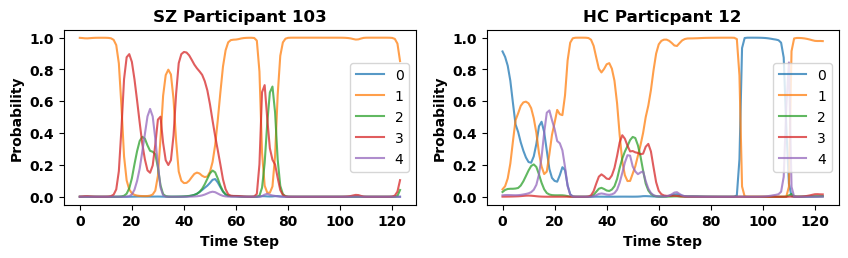

In [75]:
prob_to_plot = []
prob_to_plot.append(state_probs[:,np.squeeze(S2==103*np.ones_like(S2))]) # get SZ
prob_to_plot.append(state_probs[:,np.squeeze(S2==12*np.ones_like(S2))]) # get HC
print(np.shape(prob_to_plot))

plt.figure(figsize = (10,5))
for i in range(2):
    plt.subplot(2,2,i+1)
    plt.plot(np.array(prob_to_plot)[i,:,:].T,alpha = 0.75);
    plt.xlabel('Time Step',weight='bold')
    plt.ylabel('Probability',weight='bold')
    plt.xticks(weight='bold')
    plt.yticks(weight='bold')
    plt.legend(['0','1','2','3','4'],loc='right')
    if i == 0:
        plt.title('SZ Participant 103',weight='bold')
    else:
        plt.title('HC Particpant 12',weight='bold')
# plt.savefig("C:/Users/cellis42/Documents/AnthonyFiles/Calhoun_Lab/Projects/fMRI_Classification/Subgrouping/DataDriven/Fuzzy/Journal/Results/Results_V2/TemporalProbabilities.jpg",dpi=1200)

# Extract Traditional Features

## Calculate Occupancy Rate

In [13]:
# Calculate Occupancy Rate
ocr_vals = [];
# cluster_labels = kmeans.labels_
for i in S_sz:
    s_vals = np.array(cluster_labels)[np.squeeze(i*np.ones_like(S2)==S2)] # get cluster assignments for subject i
    values, counts = np.unique(s_vals,return_counts=True)
    
    # Make sure that if subject doesn't have a sample in a particular cluster, the missing cluster has a count of 0
    counts2 = np.zeros((top_clust,1))
    for j in range(len(values)):
        counts2[values[j]] = counts[j]
    
    ocr_vals.append(np.squeeze(counts2/(np.sum(counts2)*np.ones_like(counts2)))) # calculate OCR values

## Calculate Number of State Transitions

In [14]:
# Calculate Number of State Transitions
nst_vals = [];
# cluster_labels = kmeans.labels_
for i in S_sz:
    s_vals = np.array(cluster_labels)[np.squeeze(i*np.ones_like(S2)==S2)] # get cluster assignments for subject i    
    nst_vals.append(np.sum(np.diff(s_vals)>np.zeros((len(s_vals)-1)))) # calculate OCR values

# Extract Novel Features

## Compute KLD and Entropy-based Metrics

In [15]:
from scipy.special import kl_div
from scipy.stats import entropy

In [16]:
# Calculate KL Divergence
kld_mean_vals = []; kld_median_vals = []; kld_max_vals = []; kld_range_vals = []; kld_sd_vals = []; kld_start_stop_vals = [];
temporal_entropy = [];
# cluster_labels = kmeans.labels_
for i in S_sz:
    s_vals = np.array(state_probs)[:,np.squeeze(i*np.ones_like(S2)==S2)] # get cluster assignments for subject i
    kld_val_subj = []
    for step in range(1,np.shape(s_vals)[1]):
        kld_val_subj.append(entropy(s_vals[:,step-1],s_vals[:,step]))
    
    kld_mean_vals.append(np.mean(kld_val_subj,axis=0))
    kld_median_vals.append(np.median(kld_val_subj,axis=0))
    kld_max_vals.append(np.max(kld_val_subj,axis=0))
    kld_range_vals.append(np.ptp(kld_val_subj,axis=0))
    kld_sd_vals.append(np.std(kld_val_subj,axis=0))
    kld_start_stop_vals.append(entropy(s_vals[:,0],s_vals[:,np.shape(s_vals)[1]-1])) # KLD between first and last time point
    temporal_entropy.append(entropy(s_vals,axis=1))
    
kld_vals = np.concatenate((np.expand_dims(kld_mean_vals,axis=1),np.expand_dims(kld_median_vals,axis=1),np.expand_dims(kld_max_vals,axis=1),
               np.expand_dims(kld_range_vals,axis=1),np.expand_dims(kld_sd_vals,axis=1),
               np.expand_dims(kld_start_stop_vals,axis=1),temporal_entropy),axis=1)

## Compute Correlation-based Metrics

In [17]:
# Calculate Correlation
corr_vals = [];
abs_corr_vals = [];

for i in S_sz:
    s_vals = np.array(state_probs)[:,np.squeeze(i*np.ones_like(S2)==S2)] # get cluster assignments for subject i
    vals = np.tril(np.corrcoef(s_vals),k=-1)
    corr_vals.append(vals[np.where(vals!=0)])
    abs_corr_vals.append(np.absolute(vals[np.where(vals!=0)]))

In [18]:
corr_names = ['State 0/1 Corr', 'State 0/2 Corr','State 1/2 Corr','State 0/3 Corr','State 1/3 Corr',
             'State 2/3 Corr','State 0/4 Corr','State 1/4 Corr','State 2/4 Corr','State 3/4 Corr']

## Compute Other Descriptive Metrics

In [19]:
# Calculate Average Probability of Belonging to Cluster, Calculate Variance of Probabilities, Calculate Range of Probabilities
avg_prob_vals = [];
var_prob_vals = [];
range_prob_vals = [];
cum_dif_vals = []; # cummulative difference between probabilities for each state
nonuniformity = [];

for i in S_sz:
    avg_prob_vals.append(np.nanmean(np.array(state_probs)[:,np.squeeze(i*np.ones_like(S2)==S2)],axis=1)) # get average probabilities for subject i
    var_prob_vals.append(np.nanvar(np.array(state_probs)[:,np.squeeze(i*np.ones_like(S2)==S2)],axis=1)) # get variance of probabilities for subject i
    range_prob_vals.append(np.nanmax(np.array(state_probs)[:,np.squeeze(i*np.ones_like(S2)==S2)],axis=1)-np.nanmin(np.array(state_probs)[:,np.squeeze(i*np.ones_like(S2)==S2)],axis=1)) # get range of probabilities for subject i
    cum_dif_vals.append(np.sum(np.abs(np.diff(np.array(state_probs)[:,np.squeeze(i*np.ones_like(S2)==S2)])),axis=1))
    nonuniformity.append(np.mean(np.sum(np.abs(np.array(state_probs)[:,np.squeeze(i*np.ones_like(S2)==S2)] - 0.2),axis=0)))   

In [20]:
features = np.concatenate((np.expand_dims(nonuniformity,axis=1),kld_vals,np.expand_dims(nst_vals,axis=1),ocr_vals,
                           avg_prob_vals,var_prob_vals,range_prob_vals,cum_dif_vals,corr_vals),axis=1)
features_z = (features-np.mean(features,axis=0))/np.std(features,axis=0)

feature_names = ['Non-Uniformity','Mean KLD', 'Median KLD', 'Max KLD', 'Range KLD', 'SD KLD','Start/Stop KLD',
                 'State 0 Entropy', 'State 1 Entropy', 'State 2 Entropy', 'State 3 Entropy', 'State 4 Entropy',
                 'NST','State 0 OCR','State 1 OCR', 'State 2 OCR', 'State 3 OCR', 'State 4 OCR',
                 'State 0 Avg Prob','State 1 Avg Prob','State 2 Avg Prob', 'State 3 Avg Prob', 'State 4 Avg Prob',
                 'State 0 Var Prob', 'State 1 Var Prob','State 2 Var Prob', 'State 3 Var Prob', 'State 4 Var Prob',
                 'State 0 Range Prob','State 1 Range Prob', 'State 2 Range Prob', 'State 3 Range Prob', 'State 4 Range Prob',
                 'State 0 Cumulative Dif', 'State 1 Cumulative Dif', 'State 2 Cumulative Dif', 'State 3 Cumulative Dif', 'State 4 Cumulative Dif',
                 'State 0/1 Corr', 'State 0/2 Corr','State 1/2 Corr','State 0/3 Corr','State 1/3 Corr',
                 'State 2/3 Corr','State 0/4 Corr','State 1/4 Corr','State 2/4 Corr','State 3/4 Corr']

# Plot Features

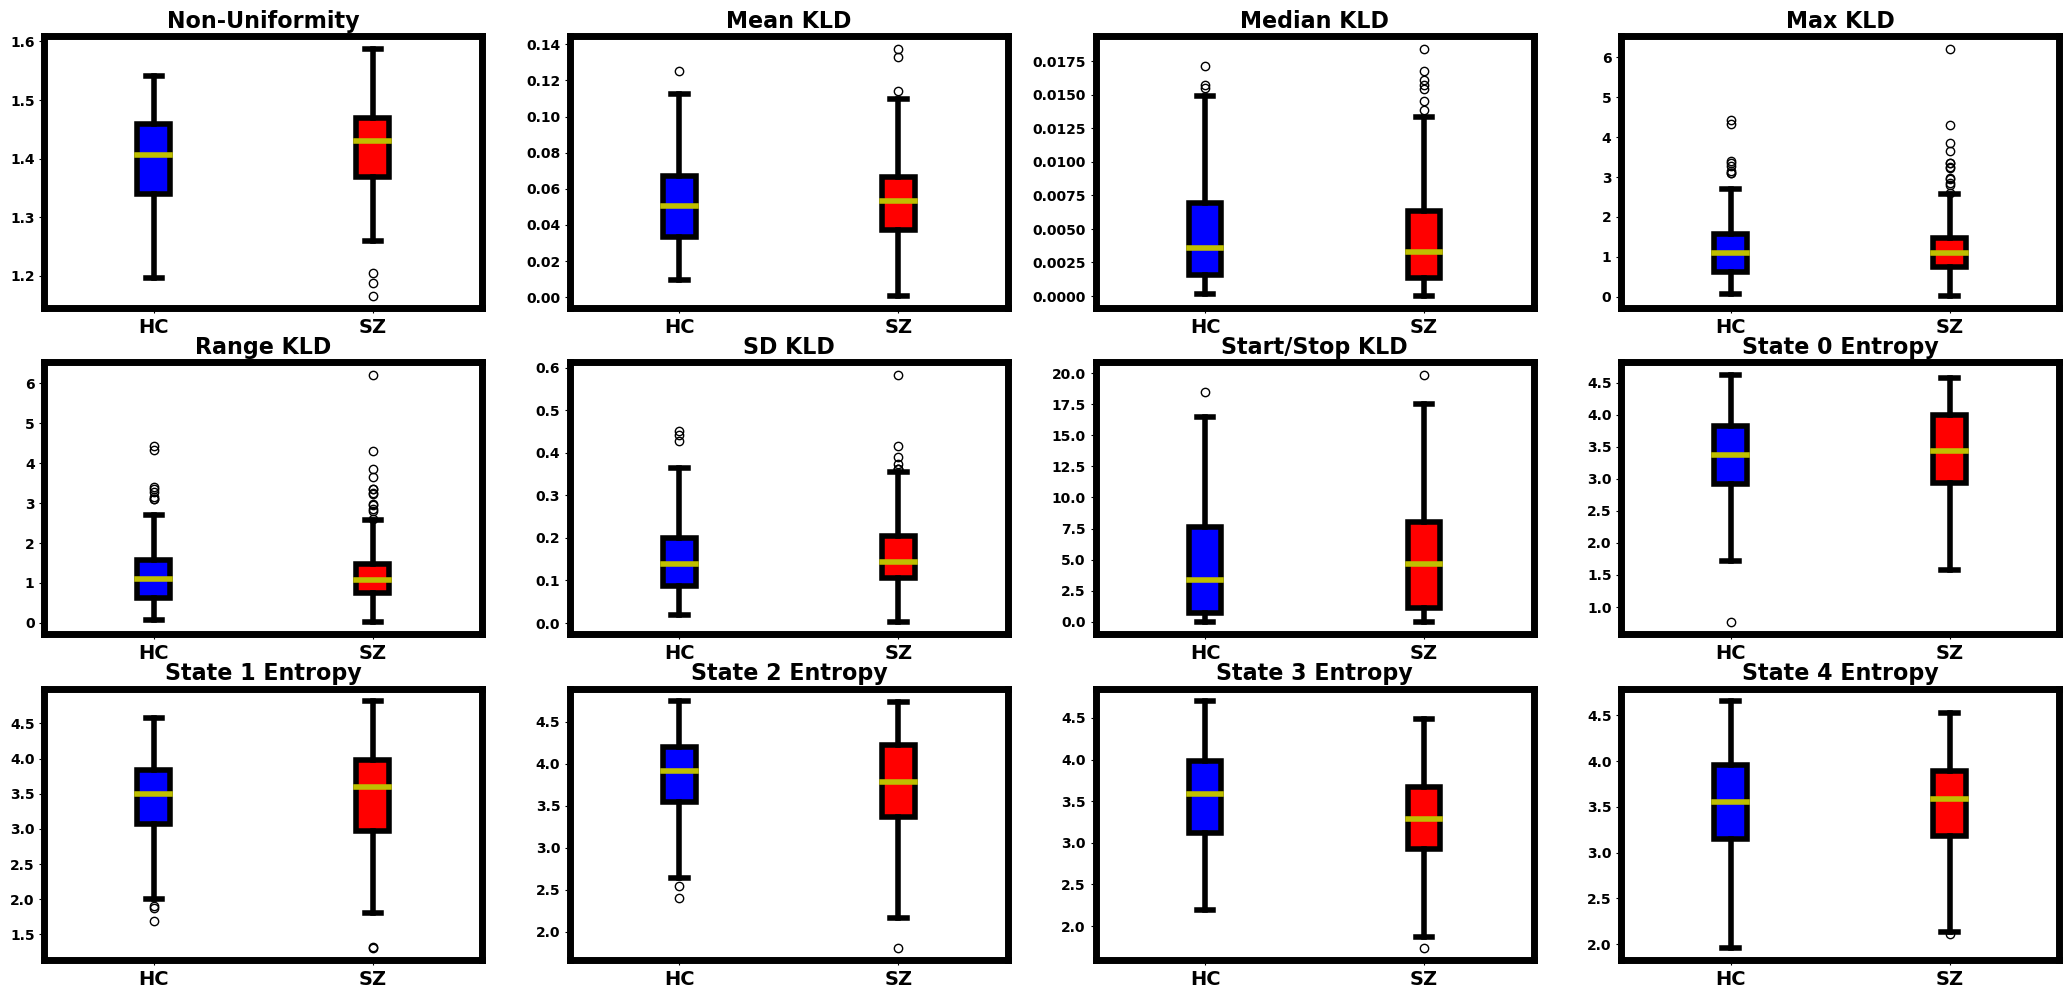

In [33]:
# Plot Non-Uniformity, KLD, and Entropy Features

plt.figure(figsize=(26,12))
for i in np.arange(12):
    plt.subplot(3,4,i+1)
    bplot_hc = plt.boxplot(features[np.squeeze(Y==np.ones_like(Y)),i],positions = [1],patch_artist=True) # HCs
    bplot_sz = plt.boxplot(features[np.squeeze(Y==np.zeros_like(Y)),i],positions= [2],patch_artist=True) # SZs
    plt.title(feature_names[i],weight='bold',fontsize=16)
    plt.xticks([1,2],['HC','SZ'],weight='bold',fontsize=14)
    plt.yticks(weight='bold')
    
    # Set Whisker Color
    for whisker in bplot_hc['whiskers']:
        whisker.set(color='k',linewidth=4)
    for whisker in bplot_sz['whiskers']:
        whisker.set(color='k',linewidth=4)
    
    # Set Caps Color
    for cap in bplot_hc['caps']:
        cap.set(color='k',linewidth=4)
    for cap in bplot_sz['caps']:
        cap.set(color='k',linewidth=4)
    
    # Set Box Outline Color
    for box in bplot_hc['boxes']:
        box.set(color='k',linewidth=4)
    for box in bplot_sz['boxes']:
        box.set(color='k',linewidth=4)
        
    # Set Median Color
    for med in bplot_hc['medians']:
        med.set(color='y',linewidth=4)
    for med in bplot_sz['medians']:
        med.set(color='y',linewidth=4)
        
    # Set Face color
    colors = ['blue','red']
    count=0
    for bplot in (bplot_hc,bplot_sz):
        for patch, color in zip(bplot['boxes'],colors[count]):
            patch.set_facecolor(color)
            count+=1
    ax = plt.gca()
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(5)
plt.savefig("C:/Users/cellis42/Documents/AnthonyFiles/Calhoun_Lab/Projects/fMRI_Classification/Subgrouping/DataDriven/Fuzzy/Journal/Results/Results_V2/Supplementary_Figure1_NonUniformity_KLD_Entropy.jpg",dpi=1200)

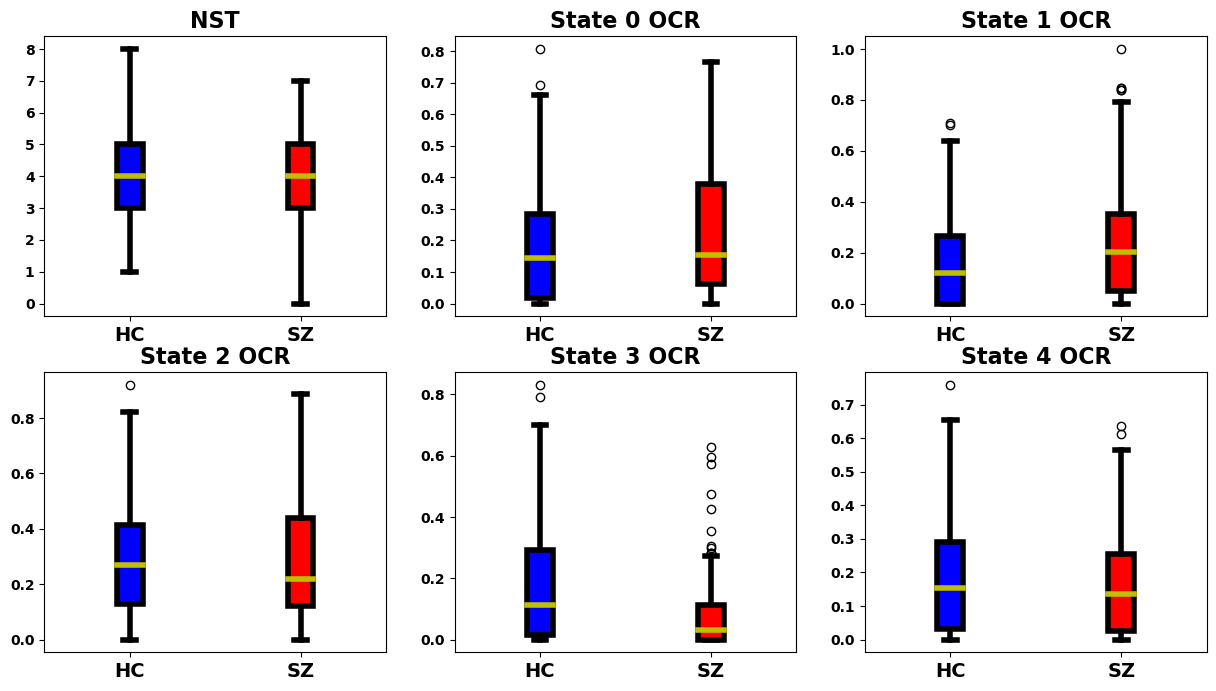

In [34]:
# Plot NST and OCR Features

plt.figure(figsize=(15,8))
for i in np.arange(12,18):
    plt.subplot(2,3,i-11)
    bplot_hc = plt.boxplot(features[np.squeeze(Y==np.ones_like(Y)),i],positions = [1],patch_artist=True) # HCs
    bplot_sz = plt.boxplot(features[np.squeeze(Y==np.zeros_like(Y)),i],positions= [2],patch_artist=True) # SZs
    plt.title(feature_names[i],weight='bold',fontsize=16)
    plt.xticks([1,2],['HC','SZ'],weight='bold',fontsize=14)
    plt.yticks(weight='bold')
    
    # Set Whisker Color
    for whisker in bplot_hc['whiskers']:
        whisker.set(color='k',linewidth=4)
    for whisker in bplot_sz['whiskers']:
        whisker.set(color='k',linewidth=4)
    
    # Set Caps Color
    for cap in bplot_hc['caps']:
        cap.set(color='k',linewidth=4)
    for cap in bplot_sz['caps']:
        cap.set(color='k',linewidth=4)
    
    # Set Box Outline Color
    for box in bplot_hc['boxes']:
        box.set(color='k',linewidth=4)
    for box in bplot_sz['boxes']:
        box.set(color='k',linewidth=4)
        
    # Set Median Color
    for med in bplot_hc['medians']:
        med.set(color='y',linewidth=4)
    for med in bplot_sz['medians']:
        med.set(color='y',linewidth=4)
    
    # Set Face color
    colors = ['blue','red']
    count=0
    for bplot in (bplot_hc,bplot_sz):
        for patch, color in zip(bplot['boxes'],colors[count]):
            patch.set_facecolor(color)
            count+=1
        
#     for axis in ['top','bottom','left','right']:
#         ax.spines[axis].set_linewidth(5)
plt.savefig("C:/Users/cellis42/Documents/AnthonyFiles/Calhoun_Lab/Projects/fMRI_Classification/Subgrouping/DataDriven/Fuzzy/Journal/Results/Results_V2/Supplementary_Figure2_NST_OCR.jpg",dpi=1200)

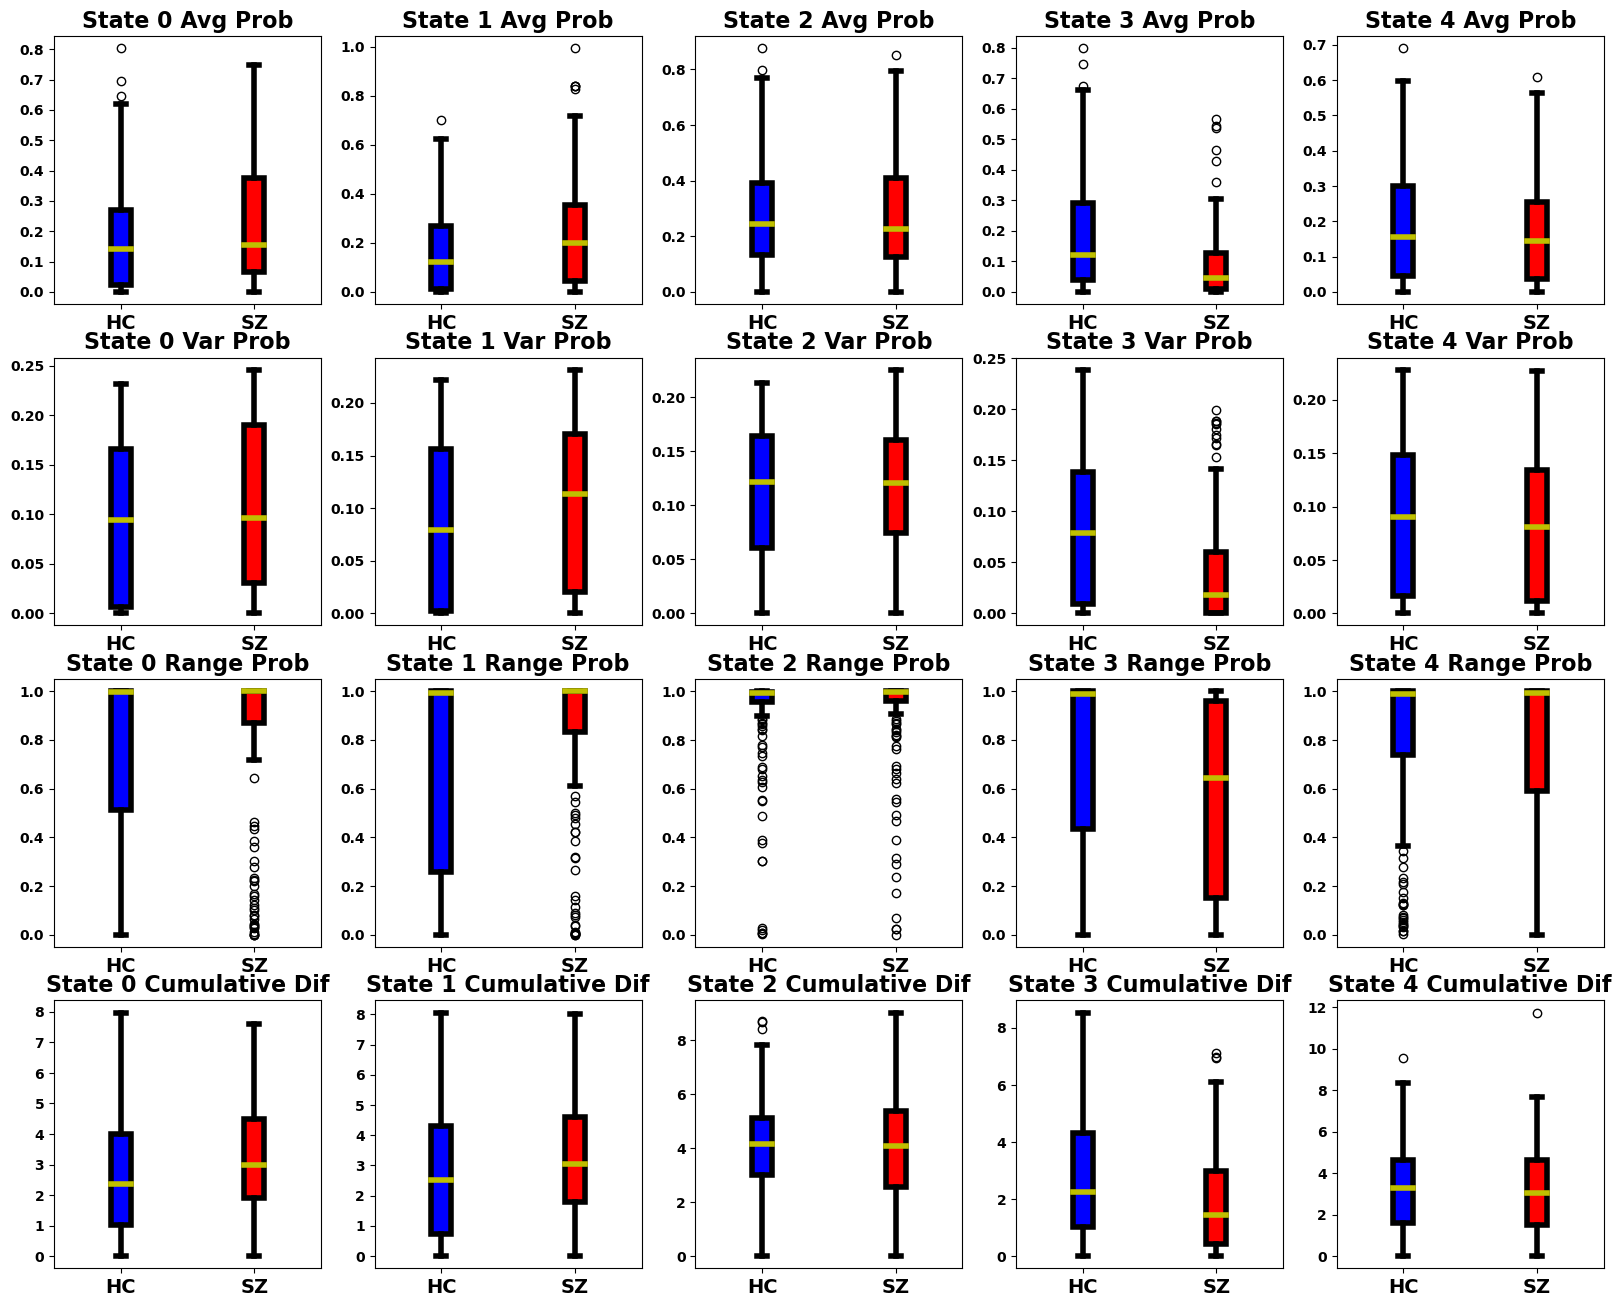

In [35]:
# Plot Avg, Var, Range, and Cumulative Difference Features

plt.figure(figsize=(20,16))
for i in np.arange(18,38):
    plt.subplot(4,5,i-17)
    bplot_hc = plt.boxplot(features[np.squeeze(Y==np.ones_like(Y)),i],positions = [1],patch_artist=True) # HCs
    bplot_sz = plt.boxplot(features[np.squeeze(Y==np.zeros_like(Y)),i],positions= [2],patch_artist=True) # SZs
    plt.title(feature_names[i],weight='bold',fontsize=16)
    plt.xticks([1,2],['HC','SZ'],weight='bold',fontsize=14)
    plt.yticks(weight='bold')
    
    # Set Whisker Color
    for whisker in bplot_hc['whiskers']:
        whisker.set(color='k',linewidth=4)
    for whisker in bplot_sz['whiskers']:
        whisker.set(color='k',linewidth=4)
    
    # Set Caps Color
    for cap in bplot_hc['caps']:
        cap.set(color='k',linewidth=4)
    for cap in bplot_sz['caps']:
        cap.set(color='k',linewidth=4)
    
    # Set Box Outline Color
    for box in bplot_hc['boxes']:
        box.set(color='k',linewidth=4)
    for box in bplot_sz['boxes']:
        box.set(color='k',linewidth=4)
        
    # Set Median Color
    for med in bplot_hc['medians']:
        med.set(color='y',linewidth=4)
    for med in bplot_sz['medians']:
        med.set(color='y',linewidth=4)
    
    # Set Face color
    colors = ['blue','red']
    count=0
    for bplot in (bplot_hc,bplot_sz):
        for patch, color in zip(bplot['boxes'],colors[count]):
            patch.set_facecolor(color)
            count+=1
        
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(5)
plt.savefig("C:/Users/cellis42/Documents/AnthonyFiles/Calhoun_Lab/Projects/fMRI_Classification/Subgrouping/DataDriven/Fuzzy/Journal/Results/Results_V2/Supplementary_Figure3_Avg_Var_Range_CumDif.jpg",dpi=1200)

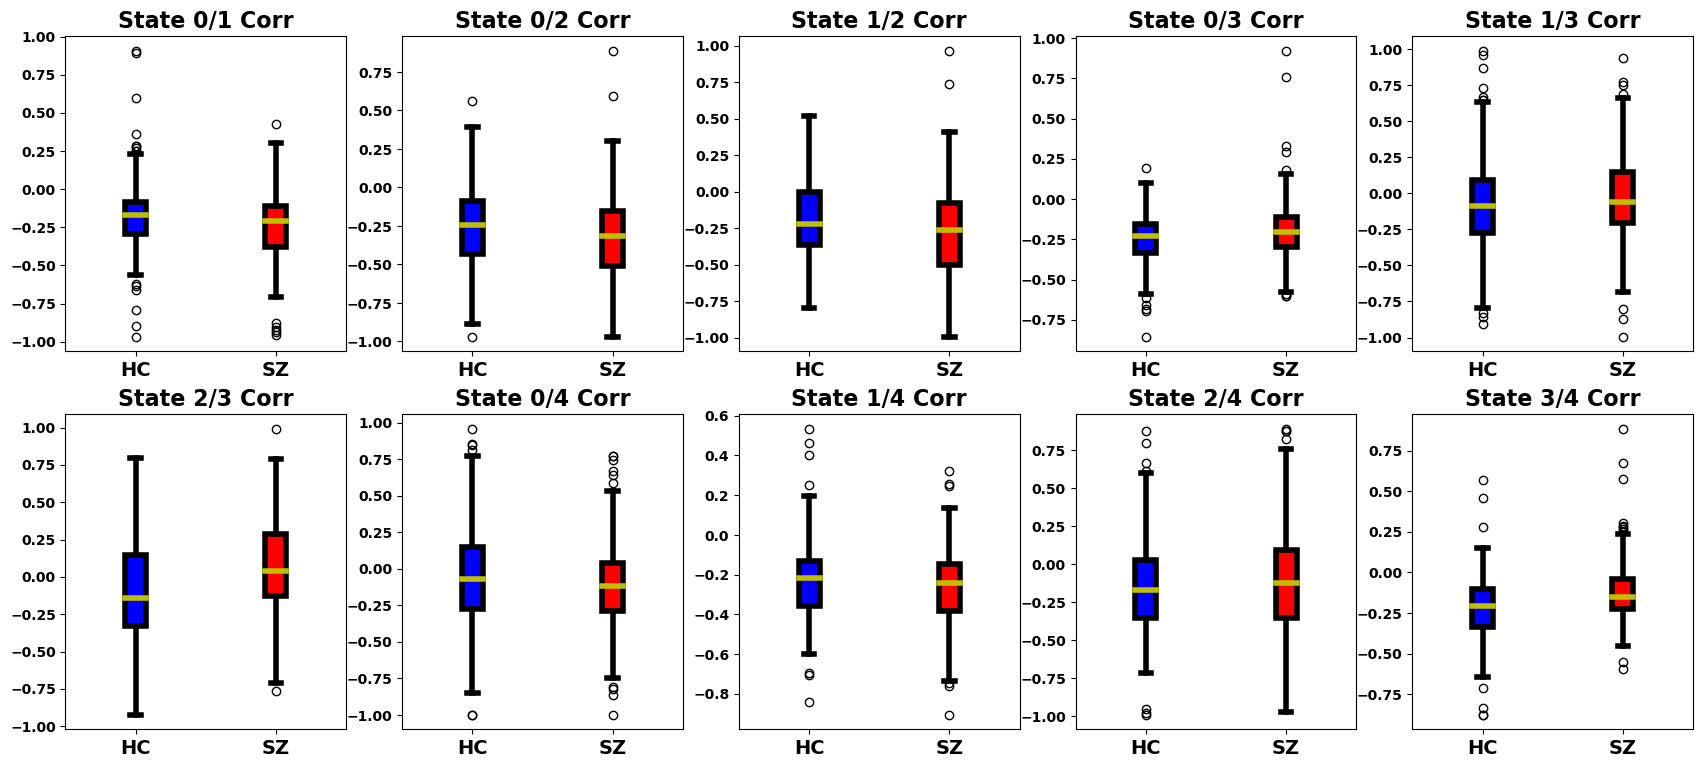

In [36]:
# Plot Correlation Features

plt.figure(figsize=(21,9))
for i in np.arange(38,48):
    plt.subplot(2,5,i-37)
    bplot_hc = plt.boxplot(features[np.squeeze(Y==np.ones_like(Y)),i],positions = [1],patch_artist=True) # HCs
    bplot_sz = plt.boxplot(features[np.squeeze(Y==np.zeros_like(Y)),i],positions= [2],patch_artist=True) # SZs
    plt.title(feature_names[i],weight='bold',fontsize=16)
    plt.xticks([1,2],['HC','SZ'],weight='bold',fontsize=14)
    plt.yticks(weight='bold')
    
    # Set Whisker Color
    for whisker in bplot_hc['whiskers']:
        whisker.set(color='k',linewidth=4)
    for whisker in bplot_sz['whiskers']:
        whisker.set(color='k',linewidth=4)
    
    # Set Caps Color
    for cap in bplot_hc['caps']:
        cap.set(color='k',linewidth=4)
    for cap in bplot_sz['caps']:
        cap.set(color='k',linewidth=4)
    
    # Set Box Outline Color
    for box in bplot_hc['boxes']:
        box.set(color='k',linewidth=4)
    for box in bplot_sz['boxes']:
        box.set(color='k',linewidth=4)
        
    # Set Median Color
    for med in bplot_hc['medians']:
        med.set(color='y',linewidth=4)
    for med in bplot_sz['medians']:
        med.set(color='y',linewidth=4)
    
    # Set Face color
    colors = ['blue','red']
    count=0
    for bplot in (bplot_hc,bplot_sz):
        for patch, color in zip(bplot['boxes'],colors[count]):
            patch.set_facecolor(color)
            count+=1
        
#     for axis in ['top','bottom','left','right']:
#         ax.spines[axis].set_linewidth(5)
plt.savefig("C:/Users/cellis42/Documents/AnthonyFiles/Calhoun_Lab/Projects/fMRI_Classification/Subgrouping/DataDriven/Fuzzy/Journal/Results/Results_V2/Supplementary_Figure4_Corr.jpg",dpi=1200)

# Statistical Testing

## HC vs SZ T-tests

In [21]:
from scipy.stats import ttest_ind

In [22]:
# Test for Significant Differences Between Features for SZs and HCs
t_stat = []; p_vals = []
for feature_idx in range(np.shape(features)[1]):
    feature = features[:,feature_idx]
    stat, p_val = ttest_ind(feature[np.squeeze(Y==np.ones_like((Y)))],feature[np.squeeze(Y==np.zeros_like((Y)))]) # HCs, SZs
    t_stat.append(stat); p_vals.append(p_val)
#     print(feature_names[feature_idx])
#     print('T-stat = ' + str(stat) + ' - P-Value = ' + str(p_val))

p_vals_corrected = p_vals.copy()

# Correct Entropy Features
p_vals_corrected[7:12] = fdrcorrection(p_vals[7:12])[1]

# Correct OCR Features
p_vals_corrected[13:18] = fdrcorrection(p_vals[13:18])[1]

# Correct Avg Prob Features
p_vals_corrected[18:23] = fdrcorrection(p_vals[18:23])[1]

# Correct Var Prob Features
p_vals_corrected[23:28] = fdrcorrection(p_vals[23:28])[1]

# Correct Range Prob Features
p_vals_corrected[28:33] = fdrcorrection(p_vals[28:33])[1]

# Correct Cumulative Difference Features
p_vals_corrected[33:38] = fdrcorrection(p_vals[33:38])[1]

# Correct Correlation Features
p_vals_corrected[38:] = fdrcorrection(p_vals[38:])[1]


for feature_idx in range(np.shape(features)[1]):
    if p_vals_corrected[feature_idx] < 0.05:
        print('\033[1m' + feature_names[feature_idx] + '\033[0m')
        print('\033[1m' + 'T-stat = ' + str(np.array(t_stat)[feature_idx]) + ' - P-Value = ' + str(p_vals_corrected[feature_idx]) + '\033[0m')
    else:
        print(feature_names[feature_idx])
        print('T-stat = ' + str(np.array(t_stat)[feature_idx]) + ' - P-Value = ' + str(p_vals_corrected[feature_idx]))
        


Non-Uniformity
T-stat = -2.2922280118941862 - P-Value = 0.022564490491961197
Mean KLD
T-stat = -1.2407577905549998 - P-Value = 0.21563643945409933
Median KLD
T-stat = 0.5492550202735826 - P-Value = 0.5832271510385953
Max KLD
T-stat = -0.915051707610503 - P-Value = 0.36087799635044393
Range KLD
T-stat = -0.9150538886848779 - P-Value = 0.36087685322111984
SD KLD
T-stat = -1.1356924044656593 - P-Value = 0.25696541299649245
Start/Stop KLD
T-stat = -1.3689592961167973 - P-Value = 0.1720062830247792
State 0 Entropy
T-stat = -1.164487135839432 - P-Value = 0.4085415208926626
State 1 Entropy
T-stat = -0.4851973070533668 - P-Value = 0.6278802018342606
State 2 Entropy
T-stat = 1.2368903529890383 - P-Value = 0.4085415208926626
State 3 Entropy
T-stat = 4.0848836026035915 - P-Value = 0.00028120986139925887
State 4 Entropy
T-stat = 0.670585317373826 - P-Value = 0.6278802018342606
NST
T-stat = -0.10420553297906232 - P-Value = 0.9170738463853759
State 0 OCR
T-stat = -2.0739218097580285 - P-Value = 0.06

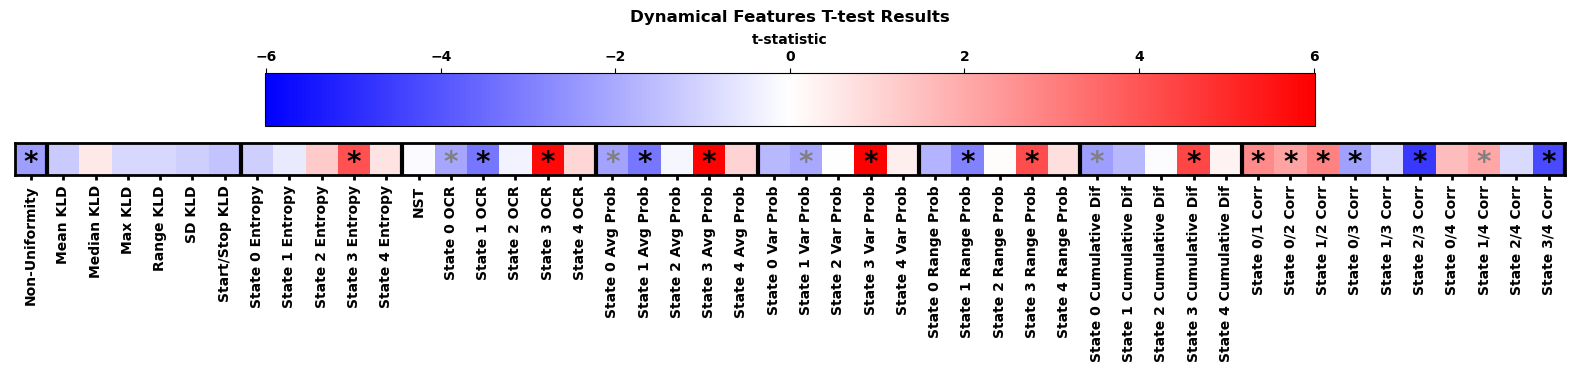

In [23]:
fig = plt.figure(figsize=(20,5))
max_val = np.max(np.abs(t_stat))
min_val = -1*max_val
plt.imshow(np.expand_dims(t_stat,axis=0), cmap = 'bwr', vmin = min_val, vmax = max_val)
plt.xticks(np.arange(len(p_vals_corrected)),feature_names,rotation=90,weight='bold')
plt.yticks([])
ax = plt.gca()
plt.vlines([0.5,6.5,11.5,17.5,22.5,27.5,32.5,37.5,47.5],-0.5,0.5,'k',linewidth=3)
ax.xaxis.set_tick_params(width=2)
ax.yaxis.set_tick_params(width=2)
for axis in ['top','bottom','left','right']:
    ax.spines[axis].set_linewidth(2)
cb = plt.colorbar(location='top')
cb.set_label(label='t-statistic',weight='bold')
plt.setp(cb.ax.get_xticklabels(),weight='bold');

for i in np.arange(len(p_vals_corrected)):
        if p_vals_corrected[i] < 0.05: # if significant with correction, add black asterisk
            plt.text(i,0,'*',horizontalalignment='center',verticalalignment='center_baseline',fontsize=20,weight='bold')
        elif p_vals[i] < 0.05: # if significant only without correction, add white asterisk
            plt.text(i,0,'*',horizontalalignment='center',verticalalignment='center_baseline',fontsize=20,color='grey',weight='bold')
plt.title('Dynamical Features T-test Results',fontsize=12,weight='bold',y = 4.5)
fig.subplots_adjust(bottom=0.15)
fig.subplots_adjust(top=0.85)
# plt.savefig("C:/Users/cellis42/Documents/AnthonyFiles/Calhoun_Lab/Projects/fMRI_Classification/Subgrouping/DataDriven/Fuzzy/Journal/Results/Results_V2/Dynamical_Features_Ttest_Results.jpg",dpi=1200)

#HCs - SZs

# Regression Analyses with Clinical Scores

In [31]:
## IMPORT DATA

datadir = "C:/Users/cellis42/Documents/AnthonyFiles/Calhoun_Lab/Projects/fMRI_Classification/Subgrouping/DataDriven/"
# filename1 = "subgroups.mat"
filename2 = "clinical_scores.mat"

# subgroups2 = loadmat(os.path.join(datadir,filename1))['subgroups2']
score_names = loadmat(os.path.join(datadir,filename2))['FILE_ID']
scores = loadmat(os.path.join(datadir,filename2))['analysis_SCORE']

In [32]:
from scipy.stats import kruskal
from scipy.stats import f_oneway
from scipy.stats import ranksums

In [33]:
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm

In [57]:
np.shape(np.concatenate((s1_vals[:,:2],to_categorical(s1_vals[:,2]),np.expand_dims(s1_vals[:,3],axis=1)),axis=1))

(151, 22)

In [34]:
# Get Columns of Interest
columns = np.arange(14)
columns = np.delete(columns,3) # don't include site
columns = np.delete(columns,2) # don't include diagnosis
columns = np.delete(columns,1) # don't include gender
columns = np.delete(columns,0) # don't include age

# Train Regression with Individual Scores as Independent Variable and Features as Dependent Variable

p_values = np.ones((np.shape(features)[1],len(columns)))
t_values = np.ones((np.shape(features)[1],len(columns)))
for feature_idx in range(np.shape(features)[1]):
    for score_idx in (4,5):#columns:
        scores_to_include = np.zeros((14,)); 
        scores_to_include[0] += 1; # include age
        scores_to_include[1] += 1; # include gender
        scores_to_include[3] += 1; # include site
        scores_to_include[score_idx] += 1; # include score of interest
#         print(np.squeeze(scores_to_include.astype(int)))
        if score_idx in (4,5):
            s1_vals = scores[np.squeeze(Y==np.zeros_like((Y))),:] # get scores for SZs
            s1_vals = s1_vals[:,np.array(scores_to_include.astype(int),dtype=bool)]
            # rename site vals
            site_val = 0
            for i in np.unique(s1_vals[:,2]):
                s1_vals[s1_vals[:,2]==i*np.ones_like(s1_vals[:,2]),2] = site_val * np.ones_like(s1_vals[s1_vals[:,2]==i*np.ones_like(s1_vals[:,2]),2])
                site_val += 1
                
            # concatenate age, gender, zero-hot encoded sites, and score of interest
            s1_vals = np.concatenate((s1_vals[:,:2],to_categorical(s1_vals[:,2]),np.expand_dims(s1_vals[:,3],axis=1)),axis=1)
            n_features = np.shape(s1_vals)[1]
            feature_vals = features[np.squeeze(Y==np.zeros_like((Y))),feature_idx] # get state features
        else:
            s1_vals = scores.copy()
            s1_vals = s1_vals[:,np.array(scores_to_include.astype(int),dtype=bool)]
            feature_vals = features[:,feature_idx] # get state features

        feature_vals = feature_vals[np.sum(np.squeeze(s1_vals==-9999*np.ones_like(s1_vals)),axis=1)==np.zeros_like(s1_vals[:,0])]
        s1_vals = s1_vals[np.sum(np.squeeze(s1_vals==-9999*np.ones_like(s1_vals)),axis=1)==np.zeros_like(s1_vals[:,0]),:]
        feature_vals = feature_vals[np.sum(np.squeeze(np.isnan(s1_vals)),axis=1)==np.zeros_like(s1_vals[:,0])] # remove samples with NaN scores
        s1_vals = s1_vals[np.sum(np.squeeze(np.isnan(s1_vals)),axis=1)==np.zeros_like(s1_vals[:,0]),:]
    
        s1_vals = sm.add_constant(s1_vals)
        results = OLS(feature_vals,s1_vals).fit()
        
        p_values[feature_idx,score_idx-4] = results.pvalues[n_features]
        t_values[feature_idx,score_idx-4] = results.tvalues[n_features]
#         print(feature_names[feature_idx] + ' vs ' + score_names[0][score_idx].item())
#         print(np.round(results.pvalues[3],5))
        
        if p_values[feature_idx,score_idx-4] < 0.05:
            print('\033[1m' + feature_names[feature_idx] + '\033[0m')
            print('\033[1m' + 'T-stat = ' + str(t_values[feature_idx,score_idx-4]) + ' - P-Value = ' + str(p_values[feature_idx,score_idx-4]) + '\033[0m')
        else:
            print(feature_names[feature_idx])
            print('T-stat = ' + str(t_values[feature_idx,score_idx-4]) + ' - P-Value = ' + str(p_values[feature_idx,score_idx-4]))
        

Non-Uniformity
T-stat = -0.1315153905210733 - P-Value = 0.8955648681430144
Non-Uniformity
T-stat = -1.1844860772874453 - P-Value = 0.23831736486327926
Mean KLD
T-stat = -0.11947465831420503 - P-Value = 0.9050782503338755
Mean KLD
T-stat = 0.8404951552261877 - P-Value = 0.4021280440757581
Median KLD
T-stat = 0.47763937318146765 - P-Value = 0.6336850969459795
Median KLD
T-stat = 1.3458154831142646 - P-Value = 0.18063464664368029
Max KLD
T-stat = -1.194011310086273 - P-Value = 0.23458295825297948
Max KLD
T-stat = 0.8834635512167744 - P-Value = 0.3785681415636215
Range KLD
T-stat = -1.1940073997599894 - P-Value = 0.23458448266445592
Range KLD
T-stat = 0.8834536740668946 - P-Value = 0.37857345663106845
SD KLD
T-stat = -0.8817739235320194 - P-Value = 0.37947803547649195
SD KLD
T-stat = 0.800013402691279 - P-Value = 0.42511901753605574
Start/Stop KLD
T-stat = -0.6346237900575682 - P-Value = 0.5267558389443595
Start/Stop KLD
T-stat = -0.24500809346062624 - P-Value = 0.8068249744638828
State 0 

# LP2D Feature Importance

In [19]:
# Sample-Level L2PD
def LP2D_sample(mdl,X,Y,n_repeats):
    Chg = np.zeros((n_repeats,np.shape(X2)[1],np.shape(X2)[0])) # preallocate output matrix number of repeats x number of features
    
    for j in range(np.shape(X2)[1]): # for j features
        for k in range(n_repeats): # for k repeats
            np.random.seed(seed=k)
            X_2 = np.copy(X); X_2[:] = X[:]; # duplicate data array
            Sub_Data = np.random.permutation(X_2[:,j]) # shuffle feature
            X_2[:,j] = Sub_Data # add shuffled data to data matrix
            
            Y_2 = cmeans_predict(X_2.T, mdl["cntr"], mdl["m"], error=mdl["error"], maxiter=mdl["maxiter"],seed=mdl["seed"])[0]
                        
            Chg[k,j,:] =  entropy(Y,Y_2) # calculate median KL Divergence
        print(f'Feature {j}')
    Chg = np.mean(Chg,axis=0)
    return(Chg)

In [20]:
from skfuzzy.cluster import cmeans_predict

In [21]:
# cmeans_mdl = {"cntr":cntr,"nclusters":top_clust,"m":np.array(best_ms)[top_clust-2],"error":0.0001,"maxiter": 1000,"seed":np.array(best_seeds)[top_clust-2]}
cmeans_mdl = {"cntr":cntr,"nclusters":top_clust,"m":np.array(best_ms)[0],"error":0.0001,"maxiter": 1000,"seed":np.array(best_seeds)[0]}

LP2D_sample_vals = LP2D_sample(cmeans_mdl, X2,state_probs,1000).T

Feature 0
Feature 1
Feature 2
Feature 3
Feature 4
Feature 5
Feature 6
Feature 7
Feature 8
Feature 9
Feature 10
Feature 11
Feature 12
Feature 13
Feature 14
Feature 15
Feature 16
Feature 17
Feature 18
Feature 19
Feature 20


In [46]:
LP2D_subject_vals = np.zeros((len(np.unique(S2)),21))

idx = 0
for i in np.unique(S2):
    LP2D_subject_vals[idx,:] = np.std(LP2D_sample_vals[np.squeeze(S2==i*np.ones_like(S2)),:],axis=0)
    
    idx += 1

In [47]:
# Test for Significant Differences Between Features for SZs and HCs
t_stat = []; p_vals = []
for feature_idx in range(np.shape(LP2D_subject_vals)[1]):
    feature = LP2D_subject_vals[:,feature_idx]
    stat, p_val = ttest_ind(feature[np.squeeze(Y==np.ones_like((Y)))],feature[np.squeeze(Y==np.zeros_like((Y)))]) # HCs, SZs
    t_stat.append(stat); p_vals.append(p_val)
#     print(np.take(DMN_names.tolist(),np.arange(0,21))[feature_idx])
#     print('T-stat = ' + str(stat) + ' - P-Value = ' + str(p_val))

_, p_vals_corrected = fdrcorrection(p_vals)

for feature_idx in range(np.shape(LP2D_subject_vals)[1]):
    
    if p_vals_corrected[feature_idx] < 0.05: # if significant bold output
        print('\033[1m' + np.take(DMN_names.tolist(),np.arange(0,21))[feature_idx] + '\033[0m')
        print('\033[1m' + 'T-stat = ' + str(stat) + ' - P-Value = ' + str(p_vals_corrected[feature_idx]) + '\033[0m')
    else:
        print(np.take(DMN_names.tolist(),np.arange(0,21))[feature_idx])
        print('T-stat = ' + str(stat) + ' - P-Value = ' + str(p_vals_corrected[feature_idx]))


PCN 2 / PCN 1
T-stat = -1.8444772820630122 - P-Value = 0.35019293921976524
ACC 1 / PCN 1
T-stat = -1.8444772820630122 - P-Value = 0.17282167351785127
PCC 1 / PCN 1
T-stat = -1.8444772820630122 - P-Value = 0.8744994044426659
ACC 2 / PCN 1
T-stat = -1.8444772820630122 - P-Value = 0.5543628246842774
PCN 3 / PCN 1
T-stat = -1.8444772820630122 - P-Value = 0.25466302247834915
PCC 2 / PCN 1
T-stat = -1.8444772820630122 - P-Value = 0.3460495053637528
ACC 1 / PCN 2
T-stat = -1.8444772820630122 - P-Value = 0.8744994044426659
PCC 1 / PCN 2
T-stat = -1.8444772820630122 - P-Value = 0.17282167351785127
ACC 2 / PCN 2
T-stat = -1.8444772820630122 - P-Value = 0.40103915569492193
PCN 3 / PCN 2
T-stat = -1.8444772820630122 - P-Value = 0.8744994044426659
PCC 2 / PCN 2
T-stat = -1.8444772820630122 - P-Value = 0.9549489525837596
PCC 1 / ACC 1
T-stat = -1.8444772820630122 - P-Value = 0.35019293921976524
ACC 2 / ACC 1
T-stat = -1.8444772820630122 - P-Value = 0.7805056972609273
PCN 3 / ACC 1
T-stat = -1.844477

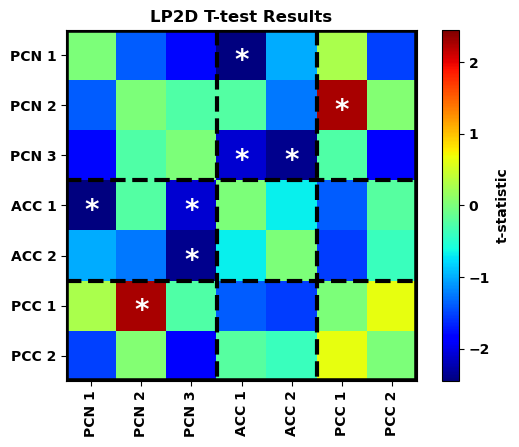

In [50]:
Nodes2 = ['PCN 1', 'PCN 2', 'PCN 3', 'ACC 1', 'ACC 2', 'PCC 1', 'PCC 2']

fig = plt.figure()
max_val = np.max(np.abs(t_stat))
min_val = -1*max_val
plt.imshow(rearrange_corrmat(vec2mat(t_stat,7)), cmap = 'jet', vmin = min_val, vmax = max_val)
plt.xticks(np.arange(0,7),Nodes2,rotation=90,weight='bold');
plt.yticks(np.arange(0,7),Nodes2,weight='bold');
plt.vlines([2.5,4.5],-0.5,6.5,'k','--',linewidth=3)
plt.hlines([2.5,4.5],-0.5,6.5,'k','--',linewidth=3)
plt.vlines([-0.5,6.5],-0.5,6.5,'k','-',linewidth=4)
plt.hlines([-0.5,6.5],-0.5,6.5,'k','-',linewidth=4)
cb = plt.colorbar()
cb.set_label(label='t-statistic',weight='bold')
plt.setp(cb.ax.get_yticklabels(),weight='bold');

p_vals2 = rearrange_corrmat(vec2mat(p_vals,7))
p_vals_corrected2 = rearrange_corrmat(vec2mat(p_vals_corrected,7))

for i in np.arange(7):
    for j in np.arange(7):
        if i!=j and p_vals_corrected2[i,j] < 0.05: # if significant with correction, add black asterisk
            plt.text(i,j,'*',horizontalalignment='center',verticalalignment='center_baseline',fontsize=20,weight='bold')
        elif i!=j and p_vals2[i,j] < 0.05: # if significant only without correction, add white asterisk
            plt.text(i,j+.05,'*',horizontalalignment='center',verticalalignment='center_baseline',fontsize=20,color='w',weight='bold')
plt.title('LP2D T-test Results',fontsize=12,weight='bold')
fig.subplots_adjust(bottom=0.15)
plt.savefig("C:/Users/cellis42/Documents/AnthonyFiles/Calhoun_Lab/Projects/fMRI_Classification/Subgrouping/DataDriven/Fuzzy/Journal/Results/Results_V2/LP2D_Ttest_Results.jpg",dpi=1200)

In [72]:
np.shape(s1_vals)

(144, 5)

In [39]:
# Get Columns of Interest
columns = np.arange(14)
columns = np.delete(columns,3) # don't include site
columns = np.delete(columns,2) # don't include diagnosis
columns = np.delete(columns,1) # don't include gender
columns = np.delete(columns,0) # don't include age

# Train Regression with Individual Scores as Independent Variable and Features as Dependent Variable

p_values = np.ones((np.shape(LP2D_subject_vals)[1],2))
p_values_corrected = np.ones((np.shape(LP2D_subject_vals)[1],2))
t_values = np.ones((np.shape(LP2D_subject_vals)[1],2))

for feature_idx in range(np.shape(LP2D_subject_vals)[1]): # iterate over each LP2D feature
    for score_idx in (4,5):#columns:
        scores_to_include = np.zeros((14,)); 
        scores_to_include[0] += 1; # include age
        scores_to_include[1] += 1; # include gender
        scores_to_include[3] += 1; # include site
        scores_to_include[score_idx] += 1; # include score of interest
        
        s1_vals = scores[np.squeeze(Y==np.zeros_like((Y))),:] # get scores for SZs
        s1_vals = s1_vals[:,np.array(scores_to_include.astype(int),dtype=bool)]
        
        # rename site vals
        site_val = 0
        for i in np.unique(s1_vals[:,2]):
            s1_vals[s1_vals[:,2]==i*np.ones_like(s1_vals[:,2]),2] = site_val * np.ones_like(s1_vals[s1_vals[:,2]==i*np.ones_like(s1_vals[:,2]),2])
            site_val += 1
            
        # concatenate age, gender, zero-hot encoded sites, and score of interest
        s1_vals = np.concatenate((s1_vals[:,:2],to_categorical(s1_vals[:,2]),np.expand_dims(s1_vals[:,3],axis=1)),axis=1)
        n_features = np.shape(s1_vals)[1]
        
        feature_vals = LP2D_subject_vals[np.squeeze(Y==np.zeros_like((Y))),feature_idx] # get state features

        feature_vals = feature_vals[np.sum(np.squeeze(s1_vals==-9999*np.ones_like(s1_vals)),axis=1)==np.zeros_like(s1_vals[:,0])]
        s1_vals = s1_vals[np.sum(np.squeeze(s1_vals==-9999*np.ones_like(s1_vals)),axis=1)==np.zeros_like(s1_vals[:,0]),:]
        feature_vals = feature_vals[np.sum(np.squeeze(np.isnan(s1_vals)),axis=1)==np.zeros_like(s1_vals[:,0])] # remove samples with NaN scores
        s1_vals = s1_vals[np.sum(np.squeeze(np.isnan(s1_vals)),axis=1)==np.zeros_like(s1_vals[:,0]),:]
    
        s1_vals = sm.add_constant(s1_vals)
        results = OLS(feature_vals,s1_vals).fit()
        
        p_values[feature_idx,score_idx-4] = results.pvalues[n_features]
        t_values[feature_idx,score_idx-4] = results.tvalues[n_features]

# Apply FDR Correction
_, p_vals_corrected1 = fdrcorrection(p_values[:,0])
p_values_corrected[:,0] = p_vals_corrected1
_, p_vals_corrected2 = fdrcorrection(p_values[:,1])
p_values_corrected[:,0] = p_vals_corrected2

for feature_idx in range(np.shape(LP2D_subject_vals)[1]): # iterate over each LP2D feature
    for score_idx in (4,5):#columns:
        print(np.take(DMN_names.tolist(),np.arange(0,21))[feature_idx] + ' vs ' + score_names[0][score_idx].item())
        print(np.round(p_values_corrected[feature_idx,score_idx-4],5))

PCN 2 / PCN 1 vs PANSS(positive)
0.53654
PCN 2 / PCN 1 vs PANSS(negative)
1.0
ACC 1 / PCN 1 vs PANSS(positive)
0.68244
ACC 1 / PCN 1 vs PANSS(negative)
1.0
PCC 1 / PCN 1 vs PANSS(positive)
0.53654
PCC 1 / PCN 1 vs PANSS(negative)
1.0
ACC 2 / PCN 1 vs PANSS(positive)
0.68223
ACC 2 / PCN 1 vs PANSS(negative)
1.0
PCN 3 / PCN 1 vs PANSS(positive)
0.88313
PCN 3 / PCN 1 vs PANSS(negative)
1.0
PCC 2 / PCN 1 vs PANSS(positive)
0.70272
PCC 2 / PCN 1 vs PANSS(negative)
1.0
ACC 1 / PCN 2 vs PANSS(positive)
0.75807
ACC 1 / PCN 2 vs PANSS(negative)
1.0
PCC 1 / PCN 2 vs PANSS(positive)
0.65256
PCC 1 / PCN 2 vs PANSS(negative)
1.0
ACC 2 / PCN 2 vs PANSS(positive)
0.68244
ACC 2 / PCN 2 vs PANSS(negative)
1.0
PCN 3 / PCN 2 vs PANSS(positive)
0.68244
PCN 3 / PCN 2 vs PANSS(negative)
1.0
PCC 2 / PCN 2 vs PANSS(positive)
0.70272
PCC 2 / PCN 2 vs PANSS(negative)
1.0
PCC 1 / ACC 1 vs PANSS(positive)
0.53654
PCC 1 / ACC 1 vs PANSS(negative)
1.0
ACC 2 / ACC 1 vs PANSS(positive)
0.82447
ACC 2 / ACC 1 vs PANSS(

In [820]:
np.shape(t_values)

(21, 2)

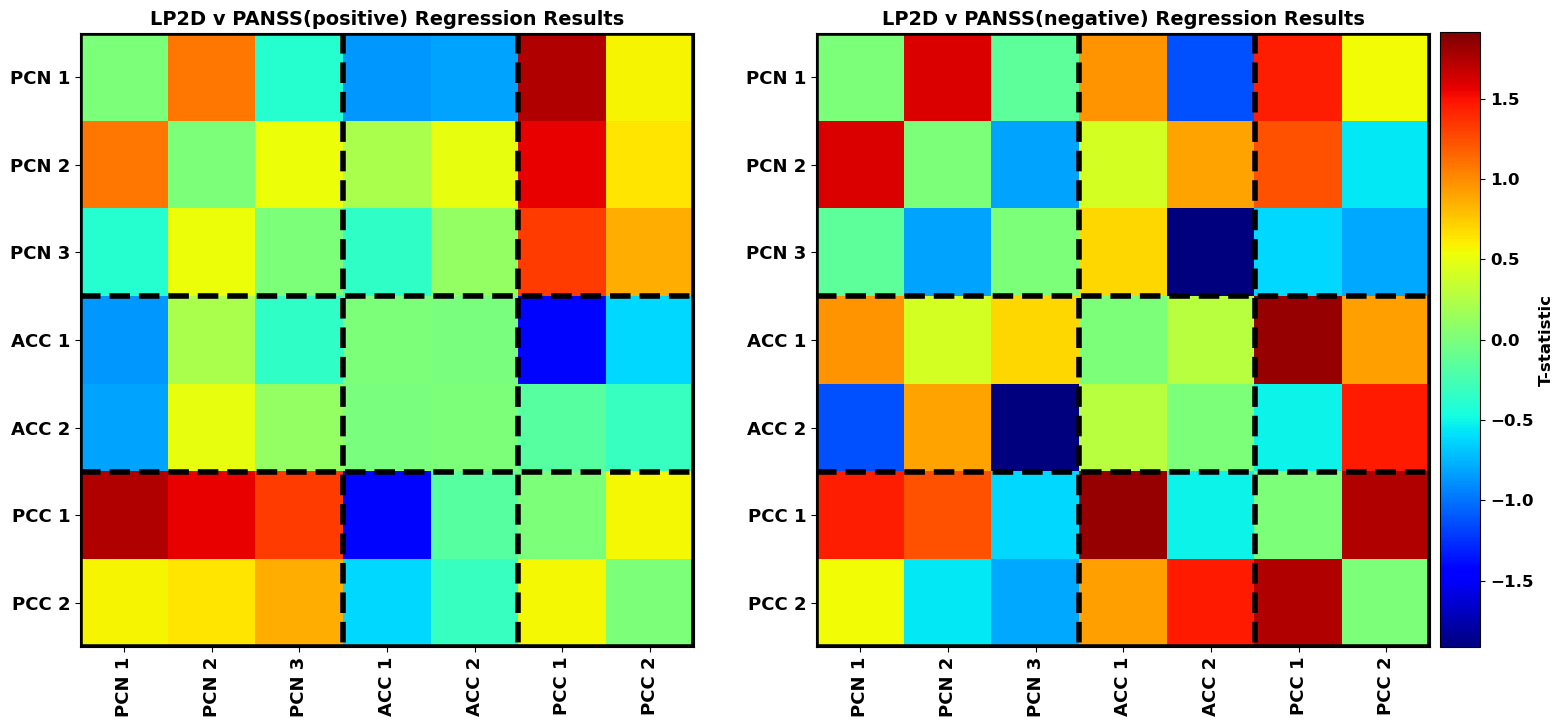

In [40]:
Nodes2 = ['PCN 1', 'PCN 2', 'PCN 3', 'ACC 1', 'ACC 2', 'PCC 1', 'PCC 2']

fig = plt.figure(figsize=(20,10))
for score in np.arange(2): # iterate over positive and negative scores
    plt.subplot(1,2,score+1)
    max_val = np.max(np.abs(t_values))
    min_val = -1*max_val
    im2 = plt.imshow(rearrange_corrmat(vec2mat(t_values[:,score],7)), cmap = 'jet', vmin = min_val, vmax = max_val)
    plt.xticks(np.arange(0,7),Nodes2,rotation=90,weight='bold',fontsize=13);
    plt.yticks(np.arange(0,7),Nodes2,weight='bold',fontsize=13);
    plt.vlines([2.5,4.5],-0.5,6.5,'k','--',linewidth=4)
    plt.hlines([2.5,4.5],-0.5,6.5,'k','--',linewidth=4)
    plt.vlines([-0.5,6.5],-0.5,6.5,'k','-',linewidth=4)
    plt.hlines([-0.5,6.5],-0.5,6.5,'k','-',linewidth=4)

    p_vals2 = rearrange_corrmat(vec2mat(p_values[:,score],7))
    p_vals_corrected2 = rearrange_corrmat(vec2mat(p_values_corrected[:,score],7))

    for i in np.arange(7):
        for j in np.arange(7):
            if i!=j and p_vals_corrected2[i,j] < 0.05: # if significant with correction, add black asterisk
                plt.text(i,j,'*',horizontalalignment='center',verticalalignment='center_baseline',fontsize=20,weight='bold')
            elif i!=j and p_vals2[i,j] < 0.05: # if significant only without correction, add white asterisk
                plt.text(i,j+.05,'*',horizontalalignment='center',verticalalignment='center_baseline',fontsize=20,color='w',weight='bold')
    if score == 0:
        plt.title('LP2D v PANSS(positive) Regression Results',fontsize=14,weight='bold')
    else:
        plt.title('LP2D v PANSS(negative) Regression Results',fontsize=14,weight='bold')
    
    fig.subplots_adjust(bottom=0.15)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.208, 0.02, 0.615]) # left bottom width height
cb = fig.colorbar(im2, cax=cbar_ax);
cb.set_label(label='T-statistic',weight='bold',fontsize=12)
plt.setp(cb.ax.get_yticklabels(),weight='bold',fontsize=12);
# plt.savefig("C:/Users/cellis42/Documents/AnthonyFiles/Calhoun_Lab/Projects/fMRI_Classification/Subgrouping/DataDriven/Fuzzy/Journal/Results/Results_V2/LP2D_PANSS_Regression_Results.jpg",dpi=1200)

# Logistic Regression Analysis of Feature Importance

In [23]:
# Logistic Regression
from sklearn.linear_model import LinearRegression, LogisticRegressionCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import roc_auc_score

In [25]:
# Classify Extracted Features and Get Their Importance Values

mean_AUC = []; sd_AUC = []; Imp = [];
mean_SENS = []; sd_SENS = []; mean_SPEC = []; sd_SPEC = [];
Feature_Names = []; Titles = []
for i in range(8): # types of extracted features
    
    if i == 0: # traditional k-means features
        features = np.concatenate((np.expand_dims(nst_vals,axis=1),ocr_vals),axis=1)
        features_z = (features-np.mean(features,axis=0))/np.std(features,axis=0)
        feature_names = ['NST','State 0 OCR','State 1 OCR', 'State 2 OCR', 'State 3 OCR', 'State 4 OCR']
        title_val = 'NST + OCR'
        
    elif i == 1: # KL Divergence-based Novel Features
        features = np.concatenate((np.expand_dims(nonuniformity,axis=1),kld_vals),axis=1)
        features_z = (features-np.mean(features,axis=0))/np.std(features,axis=0)
        feature_names = ['Non-Uniformity', 'Mean KLD', 'Median KLD', 'Max KLD', 'Range KLD', 'SD KLD','Start/Stop KLD',
                         'State 0 Entropy', 'State 1 Entropy', 'State 2 Entropy', 'State 3 Entropy', 'State 4 Entropy'] # i.e., total KLD across time steps and KLD between first and last timestep
        title_val = 'Non-Uniformity + KLD + Entropy'
        
    elif i == 2: # Novel Average Probability Features
        features = avg_prob_vals
        features_z = (features-np.mean(features,axis=0))/np.std(features,axis=0)
        feature_names = ['State 0','State 1','State 2', 'State 3', 'State 4']
        title_val = 'Average'
        
    elif i == 3: # Novel Variance in Probabilities
        features = var_prob_vals
        features_z = (features-np.mean(features,axis=0))/np.std(features,axis=0)
        feature_names = ['State 0','State 1','State 2', 'State 3', 'State 4']
        title_val = 'Variance'
        
    elif i == 4: # Novel Range of Probabilities
        features = range_prob_vals
        features_z = (features-np.mean(features,axis=0))/np.std(features,axis=0)
        feature_names = ['State 0','State 1','State 2', 'State 3', 'State 4']
        title_val = 'Range'
        
    elif i == 5: # Novel Correlation of Probabilities
        features = corr_vals
        features_z = (features-np.mean(features,axis=0))/np.std(features,axis=0)
        feature_names = ['State 0/1', 'State 0/2','State 1/2','State 0/3','State 1/3',
        'State 2/3','State 0/4','State 1/4','State 2/4','State 3/4']
        title_val = 'Correlation'
        
    elif i == 6:
        features = cum_dif_vals
        features_z = (features-np.mean(features,axis=0))/np.std(features,axis=0)
        feature_names = ['State 0','State 1','State 2', 'State 3', 'State 4']
        title_val = 'Cumulative Difference'
        
    elif i == 7: # LP2D Features
        features = LP2D_subject_vals
        features_z = (features-np.mean(features,axis=0))/np.std(features,axis=0)
        feature_names = np.take(DMN_names.tolist(),np.arange(0,21))
        title_val = 'LP2D'
        
    imp, auc, sens, spec = LR_ENR(features_z,Y)

    mean_AUC.append(np.mean(auc)); sd_AUC.append(np.std(auc)); Imp.append(imp); 
    mean_SENS.append(np.mean(sens)); sd_SENS.append(np.std(sens));
    mean_SPEC.append(np.mean(spec)); sd_SPEC.append(np.std(spec));
    Feature_Names.append(feature_names); Titles.append(title_val)

In [61]:
print('Mean AUC')
print(100*np.round(list(mean_AUC),4))
print('SD AUC')
print(100*np.round(list(sd_AUC),4))

print('Mean SENS')
print(100*np.round(list(mean_SENS),4))
print('SD SENS')
print(100*np.round(list(sd_SENS),4))

print('Mean SPEC')
print(100*np.round(list(mean_SPEC),4))
print('SD SPEC')
print(100*np.round(list(sd_SPEC),4))

Mean AUC
[66.42 58.76 68.12 66.88 65.24 68.31 62.64 49.47]
SD AUC
[6.88 4.68 6.76 6.53 6.39 4.48 8.64 3.57]
Mean SENS
[64.52 51.94 64.52 63.55 43.87 59.03 56.45 35.48]
SD SENS
[ 5.95  7.56  6.12  7.5   7.1   5.41  9.81 15.34]
Mean SPEC
[55.62 59.06 59.69 59.69 76.56 65.94 61.88 65.94]
SD SPEC
[ 8.93  7.96  7.58  7.05  8.18  6.32  9.25 15.96]


In [56]:
mean_AUC

[0.6642137096774192,
 0.587600806451613,
 0.68125,
 0.6687500000000001,
 0.6524193548387097,
 0.6830645161290322,
 0.6264112903225806,
 0.4946572580645161]

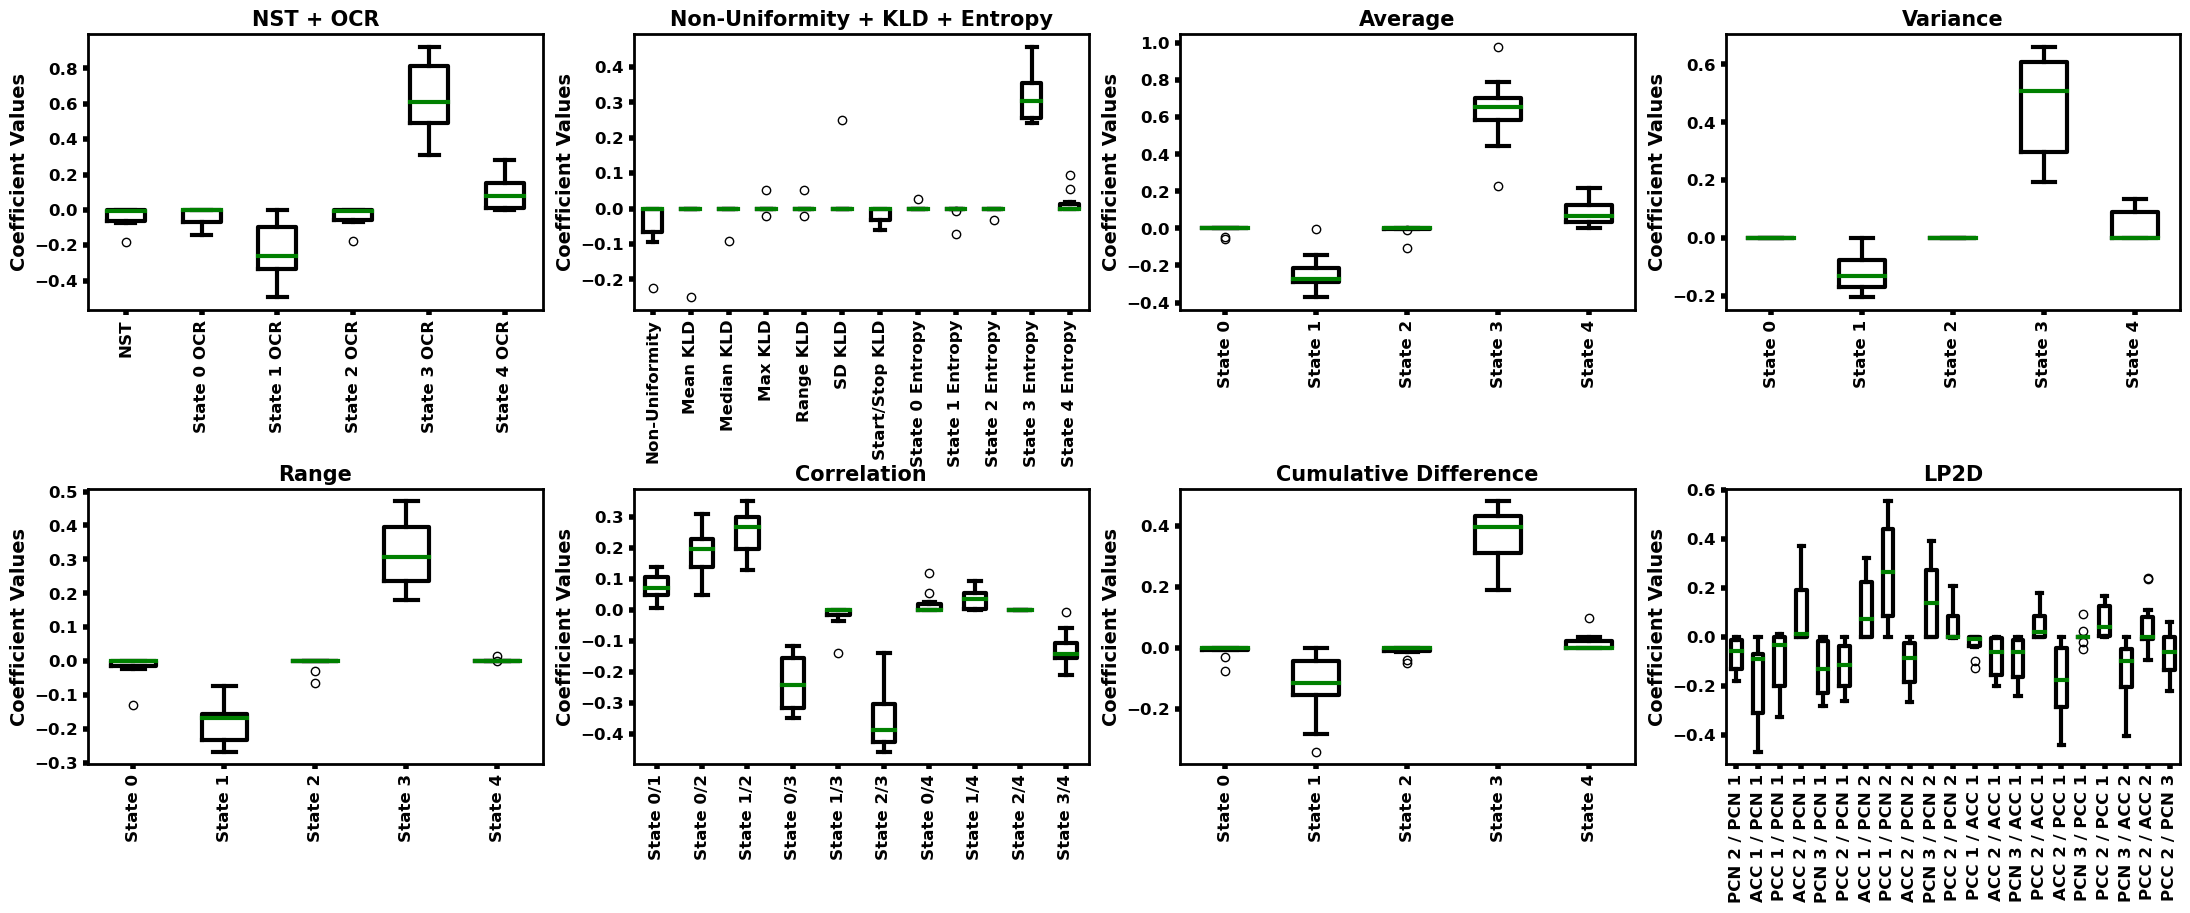

In [51]:
# Plot LR-ENR Results

fig = plt.figure(figsize=(27,10))
for i in range(8): # types of extracted features

    ax = plt.subplot(2,4,i+1)
    bp = ax.boxplot(np.array(Imp[i]));
    plt.xticks(np.arange(1,np.shape(Imp[i])[1]+1),Feature_Names[i],rotation=90,weight='bold',fontsize=12);
    ax.xaxis.set_tick_params(width=4)
    ax.yaxis.set_tick_params(width=4)
    plt.yticks(weight='bold',fontsize=12)
    ax.set_title(Titles[i],fontweight='bold',fontsize=15) # f'${Titles[i]} - AUC = {np.round(100*np.array(mean_AUC)[i],2)} \pm {np.round(100*np.array(sd_AUC)[i],2)}$'
    plt.ylabel('Coefficient Values',weight='bold',fontsize=14)
    
    for whisker in bp['whiskers']:
        whisker.set(color='k',linewidth=3)
    
    for cap in bp['caps']:
        cap.set(color='k',linewidth=3)
    
    for box in bp['boxes']:
        box.set(color='k',linewidth=3)
    
    for med in bp['medians']:
        med.set(color='g',linewidth=3)
        
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(2)

fig.subplots_adjust(hspace=.65)
fig.subplots_adjust(bottom=0.15)
plt.savefig("C:/Users/cellis42/Documents/AnthonyFiles/Calhoun_Lab/Projects/fMRI_Classification/Subgrouping/DataDriven/Fuzzy/Journal/Results/Results_V2/LR_ENR_Results.jpg",dpi=1200)

In [24]:
#%% LR-ENR

def LR_ENR(X_z,Y):
    cv_method = StratifiedShuffleSplit(n_splits=10,train_size=0.8,test_size=0.2,random_state=0)
    cv_method2 = StratifiedShuffleSplit(n_splits=10,train_size=0.8,test_size=0.2,random_state=0)
    
    imp = []; label_act = []; AUC = []; SENS = []; SPEC = [];
    
    step = 0
    for train_index, test_index in cv_method.split(X_z,Y):
        # Select data
        x_train = X_z[train_index,:]; y_train = np.squeeze(Y[train_index])
        x_test = X_z[test_index,:]; y_test = np.squeeze(Y[test_index])
        label_act.append(y_test)
        
        # Define parameter values to be considered in analysis.
        l1_ratios = [0.1, 0.15, 0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.99]; #np.linspace(0,1.0,25)
        Cs = np.geomspace(10**-4,10**4,num=100)
        
        # Train LR-ENR classifier
        clf = LogisticRegressionCV(penalty='elasticnet',solver='saga',l1_ratios=list(l1_ratios),Cs = Cs,cv=cv_method2,max_iter=200000,random_state=step,n_jobs=8).fit(x_train,y_train)
        
        # Output permutation feature importance
        imp.append(np.squeeze(clf.coef_))
        
        y_pred = clf.predict_proba(x_test)[:,1]
        
        # Compute Classification Performance
        auc = roc_auc_score(y_test,y_pred,average='weighted')
        sens = recall_score(y_test, np.round(y_pred), pos_label=0)
        spec = recall_score(y_test, np.round(y_pred), pos_label=1)

        AUC.append(auc); SENS.append(sens); SPEC.append(spec)
        
        
    return(imp,AUC,SENS,SPEC)

# Cluster Centroid Heatmaps

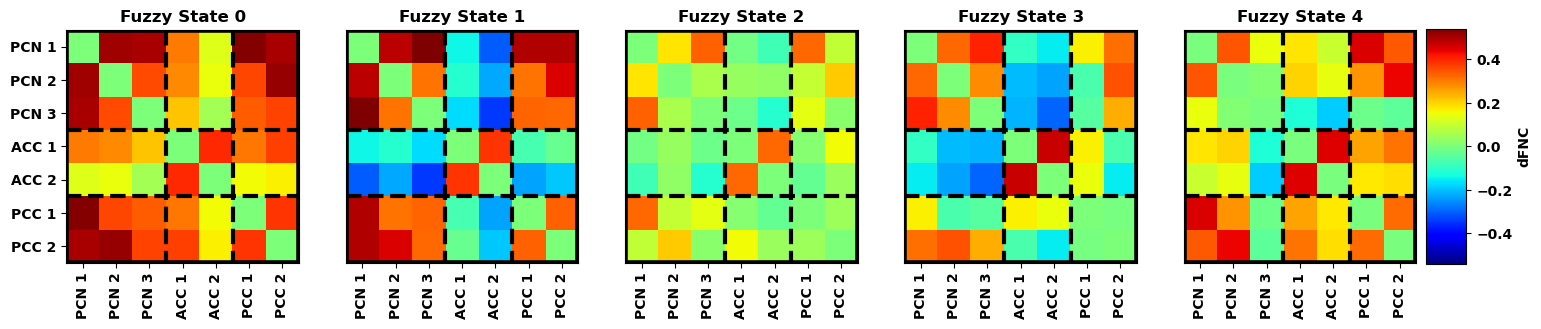

In [13]:
Nodes = ['PCN 1', 'PCN 2', 'ACC 1', 'PCC 1', 'ACC 2', 'PCN 3', 'PCC 2']
Nodes2 = ['PCN 1', 'PCN 2', 'PCN 3', 'ACC 1', 'ACC 2', 'PCC 1', 'PCC 2']

# Scale Centroids Based on Mean and Standard Deviation of Original Z-Scoring
largest_val = np.max(np.abs(cntr))
min_val = -1*largest_val
max_val = largest_val

# Make Heatmaps
fig, ax = plt.subplots(1,5,figsize=(20,5))
for i in range(5):
    im = ax[i].imshow(rearrange_corrmat(vec2mat(cntr[i,:],7)), cmap = 'jet', vmin = min_val, vmax = max_val)
    ax[i].set_xticks(np.arange(0,7))
    ax[i].set_xticklabels(Nodes2,rotation=90,weight='bold')
    ax[i].set_title(f'Fuzzy State {i}',weight='bold')
    if i == 0:
        ax[i].set_yticks(np.arange(0,7))
        ax[i].set_yticklabels(Nodes2,weight='bold')
    else:
        ax[i].set_yticks([])
    ax[i].vlines([2.5,4.5],-0.5,6.5,'k','--',linewidth=3)
    ax[i].hlines([2.5,4.5],-0.5,6.5,'k','--',linewidth=3)
    ax[i].vlines([-0.5,6.5],-0.5,6.5,'k','-',linewidth=4)
    ax[i].hlines([-0.5,6.5],-0.5,6.5,'k','-',linewidth=4)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.805, 0.26, 0.02, 0.47]) # left bottom width height
cb = fig.colorbar(im, cax=cbar_ax);
cb.set_label(label='dFNC',weight='bold')
plt.setp(cb.ax.get_yticklabels(),weight='bold');
# plt.rcParams["axes.linewidth"] = 1.5
plt.savefig("C:/Users/cellis42/Documents/AnthonyFiles/Calhoun_Lab/Projects/fMRI_Classification/Subgrouping/DataDriven/Fuzzy/Journal/Results/Results_V2/Centroids.jpg",dpi=1200)

In [12]:
def rearrange_corrmat(corrmat):
    new_order = [0,1,5,2,4,3,6]
    new_corrmat = np.zeros((7,7))
    for i in np.arange(7):
        for j in np.arange(7):
            new_corrmat[i,j] = corrmat[new_order[i],new_order[j]]
    return(new_corrmat)

def vec2mat(vec,ROI):
    matrix = np.zeros((ROI,ROI))
    #     matrix = np.chararray((ROI,ROI),itemsize=13) # if string
    
    count = 0
    for i in np.arange(ROI):
        for j in np.arange(i+1,ROI):
            
            matrix[i,j] = vec[count]
            matrix[j,i] = vec[count]
             
            count += 1

    return(matrix)

# G2PC Analysis

In [76]:
def G2PC(mdl,X,Y,n_repeats):
    Pct_Chg = np.zeros((n_repeats,np.shape(X2)[1])) # preallocate output matrix number of repeats x number of features
    
    for j in range(np.shape(X2)[1]): # for j features
        for k in range(n_repeats): # for k repeats
            np.random.seed(seed=k)
            X_2 = np.copy(X); X_2[:] = X[:]; # duplicate data array
            Sub_Data = np.random.permutation(X_2[:,j]) # shuffle feature
            X_2[:,j] = Sub_Data # add shuffled data to data matrix
            
            u = cmeans_predict(X_2.T, mdl["cntr"], mdl["m"], error=mdl["error"], maxiter=mdl["maxiter"],seed=mdl["seed"])[0]
            Y_2 = np.argmax(u,axis=0)
                        
            # print(np.sum(np.array(Y)!=np.array(Y_2))/len(np.squeeze(Y)))
            Pct_Chg[k,j] = np.sum(np.array(Y)!=np.array(Y_2))/len(np.squeeze(Y)) # calculate percent change
        print(f'Feature {j}')
    return(Pct_Chg)

In [77]:
from scipy.stats import entropy

In [79]:
cmeans_mdl = {"cntr":cntr,"nclusters":top_clust,"m":np.array(best_ms)[0],"error":0.0001,"maxiter": 1000,"seed":np.array(best_seeds)[0]}

PCT_CHG = G2PC(cmeans_mdl, X2,np.argmax(state_probs,axis=0),1000)

Feature 0
Feature 1
Feature 2
Feature 3
Feature 4
Feature 5
Feature 6
Feature 7
Feature 8
Feature 9
Feature 10
Feature 11
Feature 12
Feature 13
Feature 14
Feature 15
Feature 16
Feature 17
Feature 18
Feature 19
Feature 20


In [80]:
def GP2D(mdl,X,Y,n_repeats):
    Chg = np.zeros((n_repeats,np.shape(X2)[1])) # preallocate output matrix number of repeats x number of features
    
    for j in range(np.shape(X2)[1]): # for j features
        for k in range(n_repeats): # for k repeats
            np.random.seed(seed=k)
            X_2 = np.copy(X); X_2[:] = X[:]; # duplicate data array
            Sub_Data = np.random.permutation(X_2[:,j]) # shuffle feature
            X_2[:,j] = Sub_Data # add shuffled data to data matrix
            
            Y_2 = cmeans_predict(X_2.T, mdl["cntr"], mdl["m"], error=mdl["error"], maxiter=mdl["maxiter"],seed=mdl["seed"])[0]
                        
            Chg[k,j] =  np.median(entropy(Y,Y_2)) # calculate median KL Divergence
        print(f'Feature {j}')
    return(Chg)

In [81]:
cmeans_mdl = {"cntr":cntr,"nclusters":top_clust,"m":np.array(best_ms)[0],"error":0.0001,"maxiter": 1000,"seed":np.array(best_seeds)[0]}

GP2D_Median = GP2D(cmeans_mdl, X2,state_probs,1000)

Feature 0
Feature 1
Feature 2
Feature 3
Feature 4
Feature 5
Feature 6
Feature 7
Feature 8
Feature 9
Feature 10
Feature 11
Feature 12
Feature 13
Feature 14
Feature 15
Feature 16
Feature 17
Feature 18
Feature 19
Feature 20


In [82]:
def GP2D_Total(mdl,X,Y,n_repeats):
    Chg = np.zeros((n_repeats,np.shape(X2)[1])) # preallocate output matrix number of repeats x number of features
    
    for j in range(np.shape(X2)[1]): # for j features
        for k in range(n_repeats): # for k repeats
            np.random.seed(seed=k)
            X_2 = np.copy(X); X_2[:] = X[:]; # duplicate data array
            Sub_Data = np.random.permutation(X_2[:,j]) # shuffle feature
            X_2[:,j] = Sub_Data # add shuffled data to data matrix
            
            Y_2 = cmeans_predict(X_2.T, mdl["cntr"], mdl["m"], error=mdl["error"], maxiter=mdl["maxiter"],seed=mdl["seed"])[0]
                        
            Chg[k,j] =  np.sum(entropy(Y,Y_2)) # calculate median KL Divergence
        print(f'Feature {j}')
    return(Chg)

In [84]:
cmeans_mdl = {"cntr":cntr,"nclusters":top_clust,"m":np.array(best_ms)[0],"error":0.0001,"maxiter": 1000,"seed":np.array(best_seeds)[0]}

GP2D_Total = GP2D_Total(cmeans_mdl, X2,state_probs,1000)

Feature 0
Feature 1
Feature 2
Feature 3
Feature 4
Feature 5
Feature 6
Feature 7
Feature 8
Feature 9
Feature 10
Feature 11
Feature 12
Feature 13
Feature 14
Feature 15
Feature 16
Feature 17
Feature 18
Feature 19
Feature 20


Text(0.5, 1.0, 'Median KL Feature Importance')

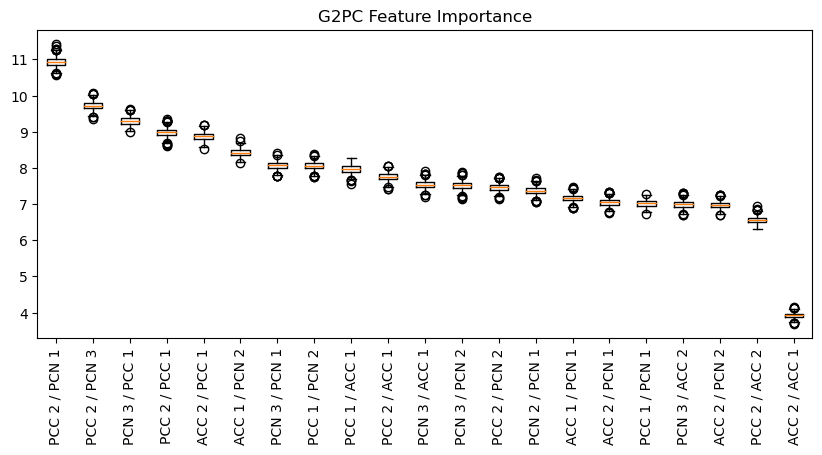

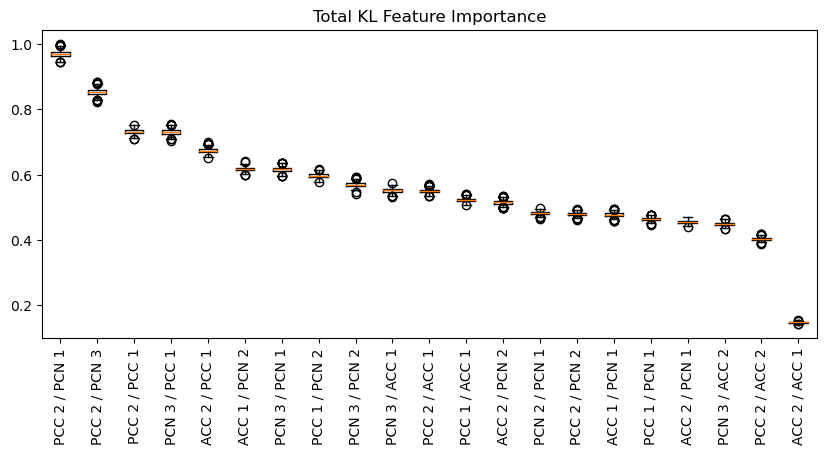

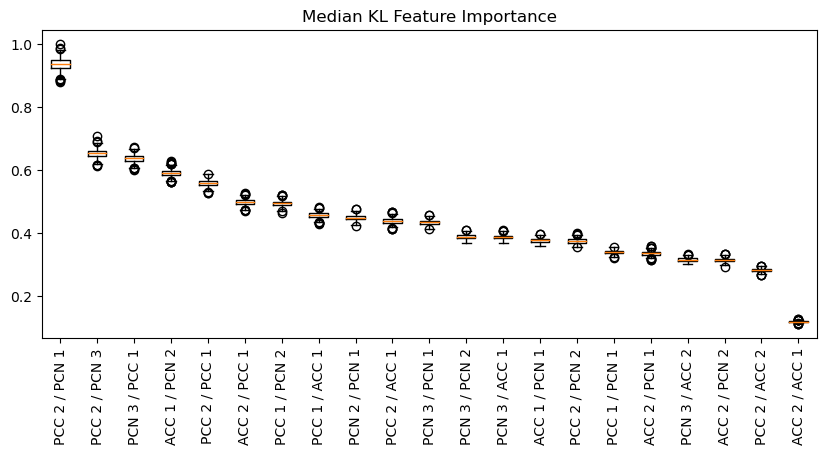

In [88]:
plt.figure(figsize=(10,4))
PCT_CHG_order = np.flip(np.argsort(np.median(PCT_CHG,axis=0)))
plt.boxplot(100*PCT_CHG[:,PCT_CHG_order]);
plt.xticks(np.arange(1,22),np.take(DMN_names.tolist(),np.arange(0,21))[PCT_CHG_order],rotation=90);
plt.title('G2PC Feature Importance')

plt.figure(figsize=(10,4))
GP2D_Total_order = np.flip(np.argsort(np.median(GP2D_Total,axis=0)))
plt.boxplot(GP2D_Total[:,GP2D_Total_order]/np.max(GP2D_Total));
plt.xticks(np.arange(1,22),np.take(DMN_names.tolist(),np.arange(0,21))[GP2D_Total_order],rotation=90);
plt.title('Total KL Feature Importance')

plt.figure(figsize=(10,4))
GP2D_Median_order = np.flip(np.argsort(np.median(GP2D_Median,axis=0)))
plt.boxplot(GP2D_Median[:,GP2D_Median_order]/np.max(GP2D_Median));
plt.xticks(np.arange(1,22),np.take(DMN_names.tolist(),np.arange(0,21))[GP2D_Median_order],rotation=90);
plt.title('Median KL Feature Importance')

In [89]:
G2PC_GP2DTotal_Overlap = kendalltau(PCT_CHG_order,GP2D_Total_order)
print(G2PC_GP2DTotal_Overlap)
G2PC_GP2DMedian_Overlap = kendalltau(PCT_CHG_order,GP2D_Median_order)
print(G2PC_GP2DMedian_Overlap)
GP2DTotal_GP2DMedian_Overlap = kendalltau(GP2D_Total_order,GP2D_Median_order)
print(GP2DTotal_GP2DMedian_Overlap)

KendalltauResult(correlation=0.6476190476190476, pvalue=1.1272480241395602e-05)
KendalltauResult(correlation=0.5333333333333333, pvalue=0.00047510411899082485)
KendalltauResult(correlation=0.39047619047619053, pvalue=0.013100682480341007)


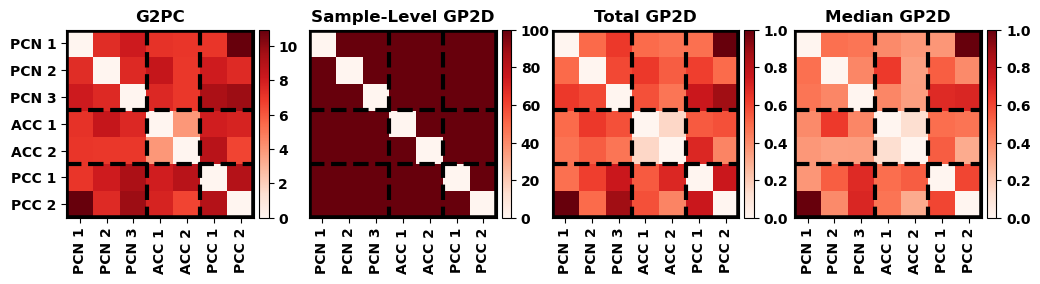

In [91]:
Nodes = ['PCN 1', 'PCN 2', 'ACC 1', 'PCC 1', 'ACC 2', 'PCN 3', 'PCC 2']
Nodes2 = ['PCN 1', 'PCN 2', 'PCN 3', 'ACC 1', 'ACC 2', 'PCC 1', 'PCC 2']

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Make Heatmaps
fig, ax = plt.subplots(1,4,figsize=(12,5))
for i in range(4):
    if i == 0:
        vals = 100*np.median(PCT_CHG,axis=0)
        t_val = 'G2PC'
    elif i == 1:
        vals = 100*np.sum(LP2D_sample_vals> np.zeros_like(LP2D_sample_vals),axis=1)/np.shape(LP2D_sample_vals)[1]
        t_val = 'Sample-Level GP2D'
    elif i == 2:
        vals = np.median(GP2D_Total,axis=0)/np.max(np.median(GP2D_Total,axis=0))
        t_val = 'Total GP2D'
    elif i == 3:
        vals = np.median(GP2D_Median,axis=0)/np.max(np.median(GP2D_Median,axis=0))
        t_val = 'Median GP2D'
        
    im = ax[i].imshow(rearrange_corrmat(vec2mat(vals,7)), cmap = 'Reds')
    ax[i].set_xticks(np.arange(0,7))
    ax[i].set_xticklabels(Nodes2,rotation=90,weight='bold')
    ax[i].set_title(t_val,weight='bold')
    if i == 0:
        ax[i].set_yticks(np.arange(0,7))
        ax[i].set_yticklabels(Nodes2,weight='bold')
    else:
        ax[i].set_yticks([])

    ax[i].vlines([2.5,4.5],-0.5,6.5,'k','--',linewidth=3)
    ax[i].hlines([2.5,4.5],-0.5,6.5,'k','--',linewidth=3)
    ax[i].vlines([-0.5,6.5],-0.5,6.5,'k','-',linewidth=4)
    ax[i].hlines([-0.5,6.5],-0.5,6.5,'k','-',linewidth=4)
    
    divider = make_axes_locatable(ax[i])
    cax = divider.append_axes('right',size='5%',pad=0.05)
    cb = fig.colorbar(im,cax=cax,orientation='vertical')
    plt.setp(cb.ax.get_yticklabels(),weight='bold');

plt.savefig("C:/Users/cellis42/Documents/AnthonyFiles/Calhoun_Lab/Projects/fMRI_Classification/Subgrouping/DataDriven/Fuzzy/Journal/Results/Results_V2/Explainability.jpg",dpi=1200)

# Methods Figure

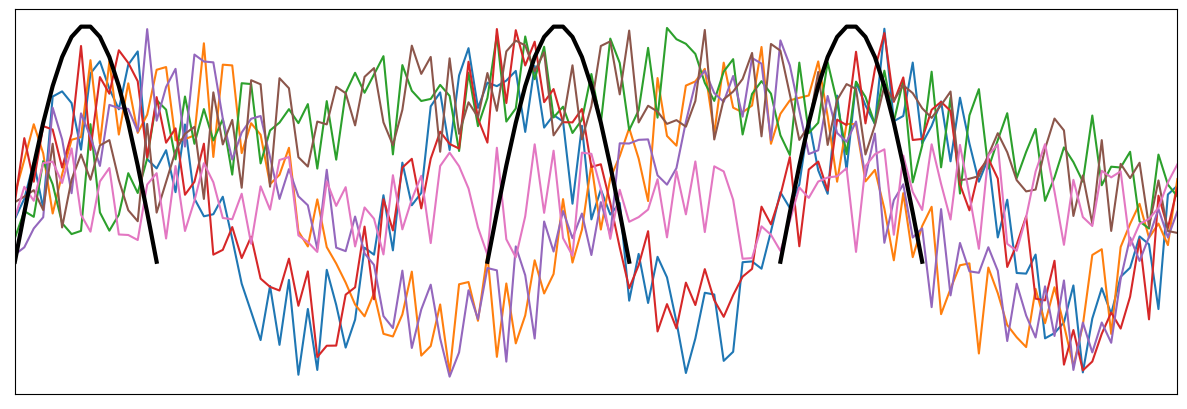

In [637]:
# Generate Random Time-Series

Simulated_time_series = np.random.rand(7,124)
Simulated_time_series[0,:] = (Simulated_time_series[0,:]+np.sin(np.arange(0,2*np.pi*3,2*np.pi*3/124)))
Simulated_time_series[1,:] = (Simulated_time_series[1,:]+np.sin(np.arange(0,2*np.pi*2,2*np.pi*2/124)))
Simulated_time_series[2,:] = (Simulated_time_series[2,:]+np.sin(np.arange(0,2*np.pi*0.5,2*np.pi*0.5/124)))
Simulated_time_series[3,:] = (Simulated_time_series[3,:]+np.sin(np.arange(0,2*np.pi*3,2*np.pi*3/124)))
Simulated_time_series[4,:] = (Simulated_time_series[4,:]+np.sin(np.arange(0,2*np.pi*2,2*np.pi*2/124)))
Simulated_time_series[5,:] = (Simulated_time_series[5,:]+np.sin(np.arange(0,2*np.pi*0.5,2*np.pi*0.5/124)))

plt.figure(figsize=(15,5))
plt.plot(Simulated_time_series.T);
plt.plot(2*np.sin(np.arange(0,2*np.pi*1,2*np.pi*1/30))[:16],'k',linewidth=3);
window = np.zeros((124,)); window[:] = np.nan; window[50:66] = 2*np.sin(np.arange(0,2*np.pi*1,2*np.pi*1/30))[:16]
plt.plot(window,'k',linewidth=3);
window = np.zeros((124,)); window[:] = np.nan; window[81:97] = 2*np.sin(np.arange(0,2*np.pi*1,2*np.pi*1/30))[:16]
plt.plot(window,'k',linewidth=3);
plt.xticks([])
plt.yticks([])
plt.xlim([0,123]);
# ax = gca();
# ax.remove()

([], [])

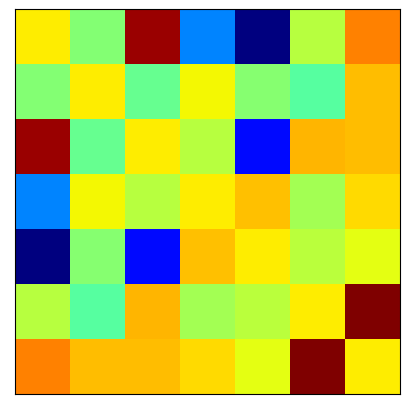

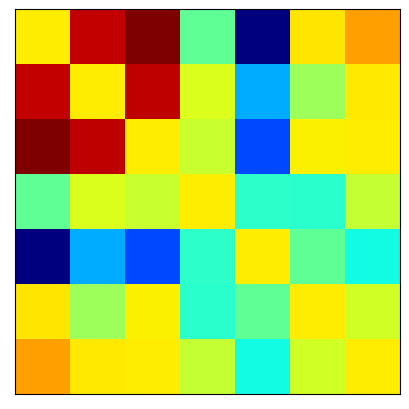

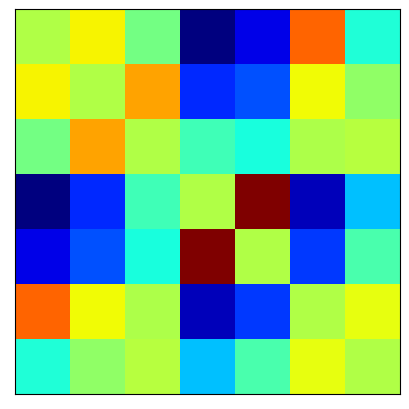

In [648]:
# dFNC Matrices

plt.figure(figsize=(5,5))
plt.imshow(rearrange_corrmat(vec2mat(X[0,0,DMN_idx],7)), cmap = 'jet')
plt.xticks([])
plt.yticks([])

plt.figure(figsize=(5,5))
plt.imshow(rearrange_corrmat(vec2mat(X[0,60,DMN_idx],7)), cmap = 'jet')
plt.xticks([])
plt.yticks([])

plt.figure(figsize=(5,5))
plt.imshow(rearrange_corrmat(vec2mat(X[0,80,DMN_idx],7)), cmap = 'jet')
plt.xticks([])
plt.yticks([])

In [643]:
np.shape()

(21,)